In [ ]:
!pip install xgboost
!pip install datasets
!pip install transformers
!pip install keras_tuner

In [ ]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, multilabel_confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf
from datasets import load_dataset
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
import re

## EDA

README.md:   0%|          | 0.00/5.25k [00:00<?, ?B/s]

(…)-00000-of-00001-46692d7e0c0147a4.parquet:   0%|          | 0.00/6.10M [00:00<?, ?B/s]

(…)-00000-of-00001-9e6cdf9c1f2a20a4.parquet:   0%|          | 0.00/767k [00:00<?, ?B/s]

(…)-00000-of-00001-0acb4be83ca6567e.parquet:   0%|          | 0.00/761k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

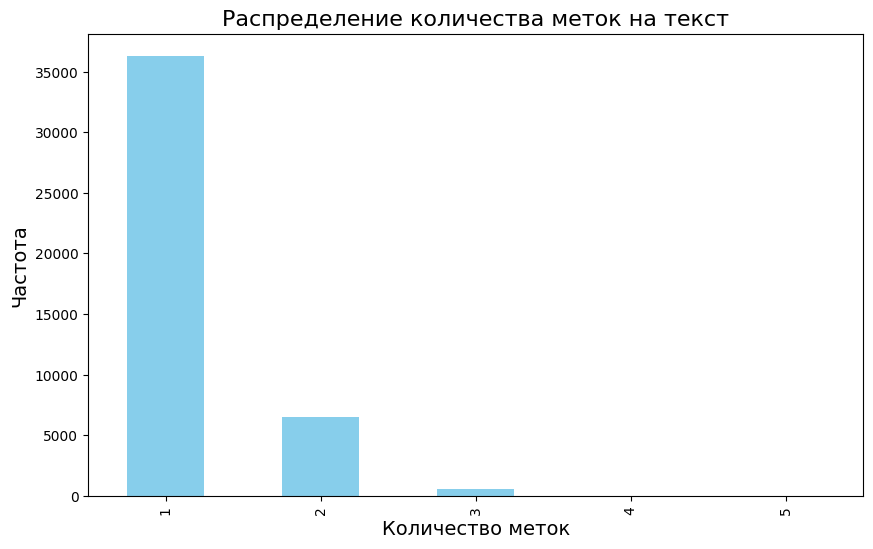

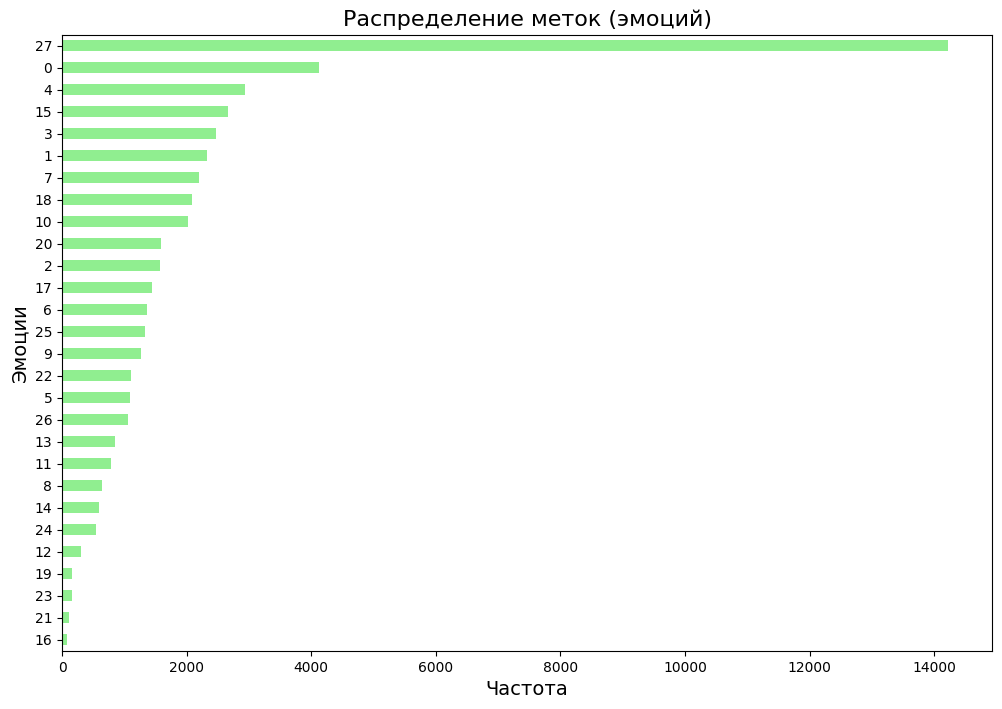

Количество меток после бинаризации: 28
Список меток: [0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27]


In [ ]:
import joblib
# Загрузка данных
dataset = load_dataset("seara/ru_go_emotions", "simplified")

# Преобразование в pandas DataFrame
train_data = dataset['train'].to_pandas()

# Бинаризация меток
mlb = MultiLabelBinarizer()
label_binarized = pd.DataFrame(mlb.fit_transform(train_data['labels']),
                               columns=mlb.classes_,
                               index=train_data.index)

# Добавление бинаризованных меток к DataFrame
train_data = pd.concat([train_data, label_binarized], axis=1)

# Сохранение объекта MultiLabelBinarizer для использования на следующих шагах
joblib.dump(mlb, 'mlb.pkl')

# Создание столбца `label_count` для подсчета количества меток на текст
train_data['label_count'] = train_data[mlb.classes_].sum(axis=1)

# Визуализация распределения количества меток
plt.figure(figsize=(10, 6))
train_data['label_count'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Распределение количества меток на текст', fontsize=16)
plt.xlabel('Количество меток', fontsize=14)
plt.ylabel('Частота', fontsize=14)
plt.show()

# Визуализация распределения каждой метки
label_counts = train_data[mlb.classes_].sum()
plt.figure(figsize=(12, 8))
label_counts.sort_values().plot(kind='barh', color='lightgreen')
plt.title('Распределение меток (эмоций)', fontsize=16)
plt.xlabel('Частота', fontsize=14)
plt.ylabel('Эмоции', fontsize=14)
plt.show()

# Проверка меток
print("Количество меток после бинаризации:", len(mlb.classes_))
print("Список меток:", mlb.classes_)

## Preprocessing

In [ ]:
import nltk
from nltk.corpus import stopwords

# Загрузка списка стоп-слов
nltk.download('stopwords')
russian_stopwords = set(stopwords.words('russian'))

# Очистка текстов
def preprocess_text(text):
    """
    Очищает текст от ссылок, символов, приводит к нижнему регистру и удаляет стоп-слова.
    Args:
        text (str): Исходный текст.
    Returns:
        str: Очищенный текст.
    """
    text = re.sub(r'http\S+', '', text)  # Удаление ссылок
    text = re.sub(r'[^\w\s]', '', text)  # Удаление спецсимволов
    text = text.lower()  # Приведение к нижнему регистру
    # Удаление стоп-слов
    words = text.split()
    words = [word for word in words if word not in russian_stopwords]
    return ' '.join(words)

# Определяем столбцы меток
y_columns = train_data.columns[3:]
y_columns = y_columns.drop("id")

# Удалим строки с NaN в метках
train_data_cleaned = train_data.dropna(subset=y_columns)

# Убедимся, что после удаления NaN в метках осталось достаточно данных
if len(train_data_cleaned) == 0:
    raise ValueError("После удаления строк с NaN в метках не осталось данных для обучения.")

# Применяем предобработку текстов
train_data_cleaned['text'] = train_data_cleaned['ru_text'].apply(preprocess_text)

# Разделение данных
X = train_data_cleaned['text']  # Тексты
y = train_data_cleaned[y_columns].astype(int)  # Метки как числовые значения

# Проверка, что данные есть для разделения
if len(X) == 0 or len(y) == 0:
    raise ValueError("После очистки данных нет доступных текстов или меток для разделения.")

# Разделяем на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Выводим размеры выборок для проверки
print(f"Размер обучающей выборки (X_train): {len(X_train)}")
print(f"Размер тестовой выборки (X_test): {len(X_test)}")

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Размер обучающей выборки (X_train): 34728
Размер тестовой выборки (X_test): 8682


In [ ]:
# Проверка количества текста после очистки
train_data['text_length'] = train_data['text'].apply(len)
print(f"Минимальная длина текста: {train_data['text_length'].min()}")
print(f"Средняя длина текста: {train_data['text_length'].mean()}")
print(f"Максимальная длина текста: {train_data['text_length'].max()}")

Минимальная длина текста: 2
Средняя длина текста: 68.40087537433772
Максимальная длина текста: 703


## Baseline

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, multilabel_confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import numpy as np

# Загрузка сохраненного объекта MultiLabelBinarizer
mlb = joblib.load('mlb.pkl')

# Бинаризация меток для train/test данных
y_train_binarized = y_train.drop(columns=['label_count']).values
y_test_binarized = y_test.drop(columns=['label_count']).values

# Преобразование текстов в Bag-of-Words
vectorizer_bow = CountVectorizer(max_features=5000, min_df=2)
X_train_bow = vectorizer_bow.fit_transform(X_train)
X_test_bow = vectorizer_bow.transform(X_test)

# Обучение модели с учетом class_weight
multi_target_lr = OneVsRestClassifier(
    LogisticRegression(class_weight="balanced", max_iter=1000)
)

multi_target_lr.fit(X_train_bow, y_train_binarized)

# Предсказания
baseline_predictions = multi_target_lr.predict(X_test_bow)

## Оценка качества, анализ ошибок

In [ ]:
# Декодируем метки из бинарного формата в исходный список меток
predicted_labels = mlb.inverse_transform(baseline_predictions)
true_labels = mlb.inverse_transform(y_test_binarized)

# Вывод первых 10 текстов и их меток
for i in range(10):
    print(f"Текст {i + 1}: {X_test.iloc[i]}")  # Используем iloc для доступа по позиции
    print(f"Предсказанные метки: {predicted_labels[i]}")
    print(f"Правильные метки: {true_labels[i]}")
    print("-" * 80)

Текст 1: это работает случае имя выполняет задание птичий короб видит условий контракта
Предсказанные метки: (10, 26, 27)
Правильные метки: (27,)
--------------------------------------------------------------------------------
Текст 2: доступ должен ограничен уничтожается
Предсказанные метки: (7, 10, 27)
Правильные метки: (3,)
--------------------------------------------------------------------------------
Текст 3: совершенно справедливо пытался всем напомнить это влюбляться тебе нравится
Предсказанные метки: (4, 10, 17, 18)
Правильные метки: (4,)
--------------------------------------------------------------------------------
Текст 4: полиэтиолог живу районе роли переехал сюда работе жены удивлен обнаружив людей упоминают хаха
Предсказанные метки: (1, 26)
Правильные метки: (26,)
--------------------------------------------------------------------------------
Текст 5: наумэн мужчинамасайнам приходится легче большинство моих асанских друзей симпатичные мальчики ебаный мальчик лол
Предск

In [ ]:
# Вывод метрик для каждой эмоции
for i, emotion in enumerate(mlb.classes_):
    print(f'Эмоция: {emotion}')
    print(classification_report(y_test_binarized[:, i], baseline_predictions[:, i]))

Эмоция: 0
              precision    recall  f1-score   support

           0       0.96      0.90      0.93      7819
           1       0.43      0.69      0.53       863

    accuracy                           0.88      8682
   macro avg       0.70      0.80      0.73      8682
weighted avg       0.91      0.88      0.89      8682

Эмоция: 1
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      8229
           1       0.58      0.82      0.68       453

    accuracy                           0.96      8682
   macro avg       0.79      0.89      0.83      8682
weighted avg       0.97      0.96      0.96      8682

Эмоция: 2
              precision    recall  f1-score   support

           0       0.98      0.91      0.95      8359
           1       0.20      0.57      0.30       323

    accuracy                           0.90      8682
   macro avg       0.59      0.74      0.62      8682
weighted avg       0.95      0.90      0.92 

In [ ]:
# Рассчитываем общую accuracy
overall_accuracy = accuracy_score(y_test_binarized, baseline_predictions)
print(f"Общая accuracy: {overall_accuracy:.4f}")

Общая accuracy: 0.1118


In [ ]:
# Расчет макро-усредненных метрик
precision_macro = np.mean([precision_score(y_test_binarized[:, i], baseline_predictions[:, i]) for i in range(y_test_binarized.shape[1])])
recall_macro = np.mean([recall_score(y_test_binarized[:, i], baseline_predictions[:, i]) for i in range(y_test_binarized.shape[1])])
f1_macro = np.mean([f1_score(y_test_binarized[:, i], baseline_predictions[:, i]) for i in range(y_test_binarized.shape[1])])

print(f"Макро-усредненная точность (precision): {precision_macro:.4f}")
print(f"Макро-усредненная полнота (recall): {recall_macro:.4f}")
print(f"Макро-усредненный F1-скор: {f1_macro:.4f}")

Макро-усредненная точность (precision): 0.2176
Макро-усредненная полнота (recall): 0.5147
Макро-усредненный F1-скор: 0.2928


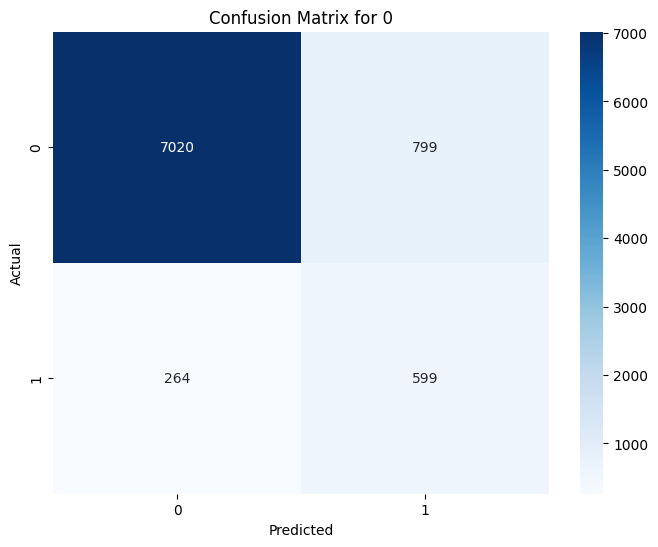

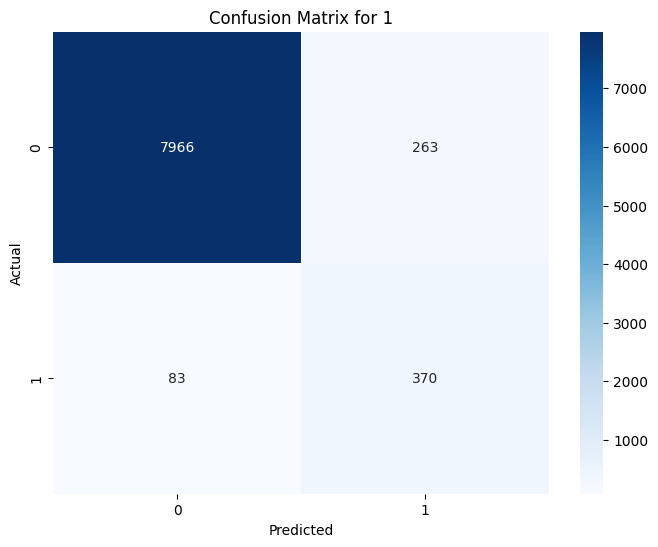

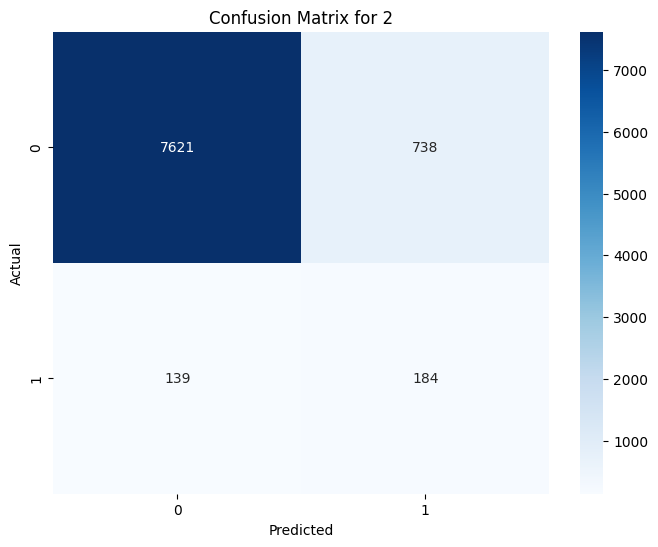

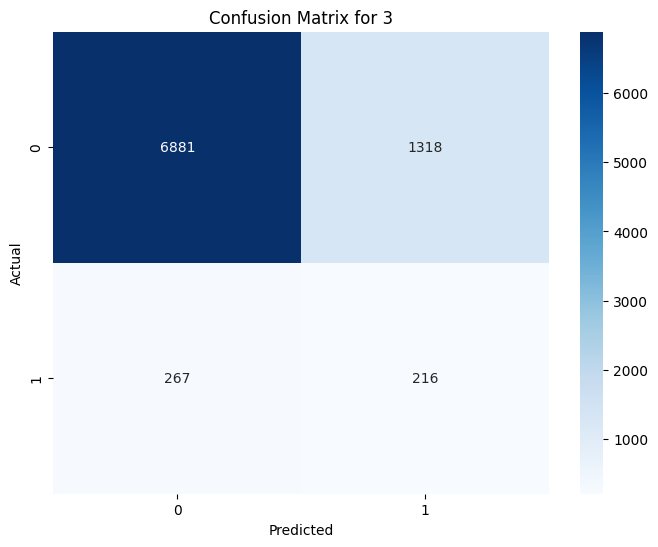

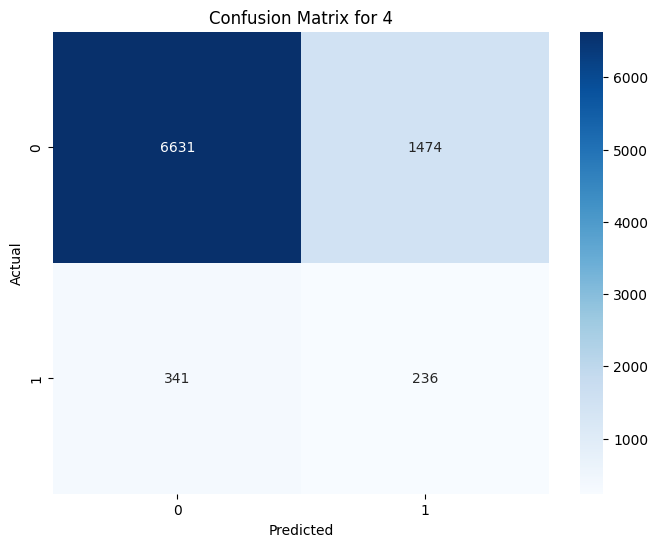

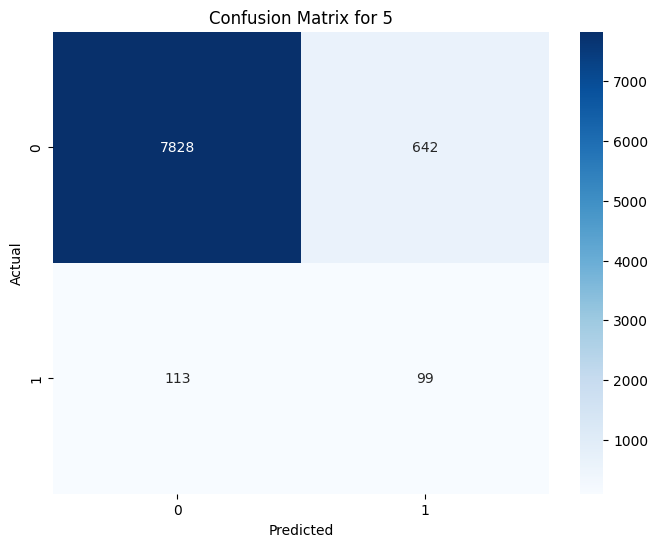

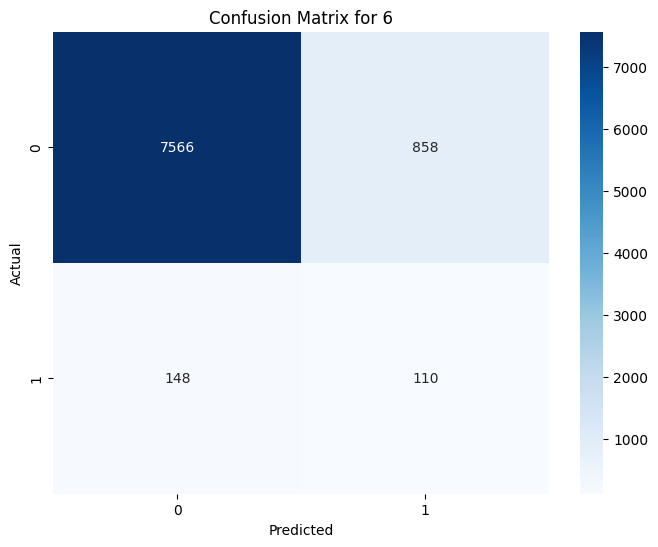

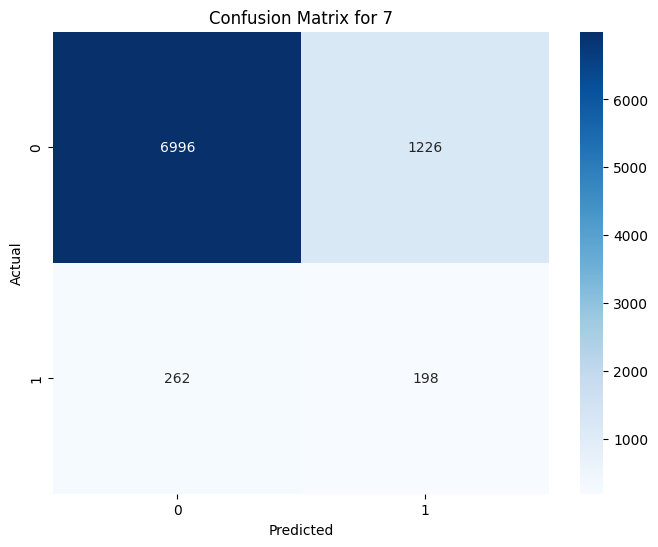

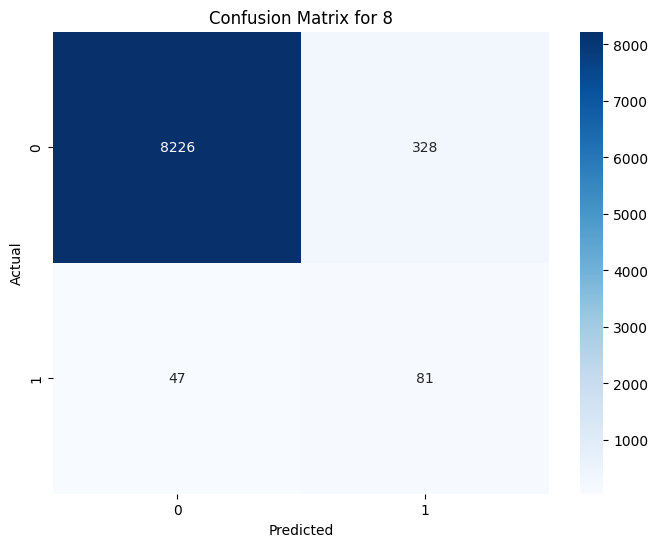

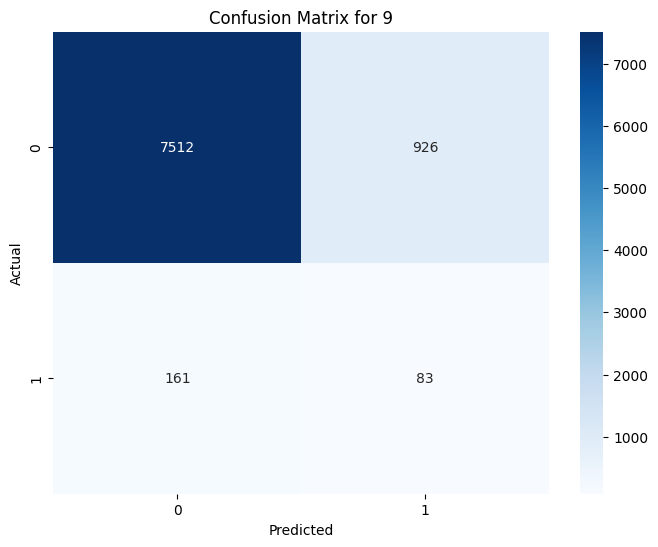

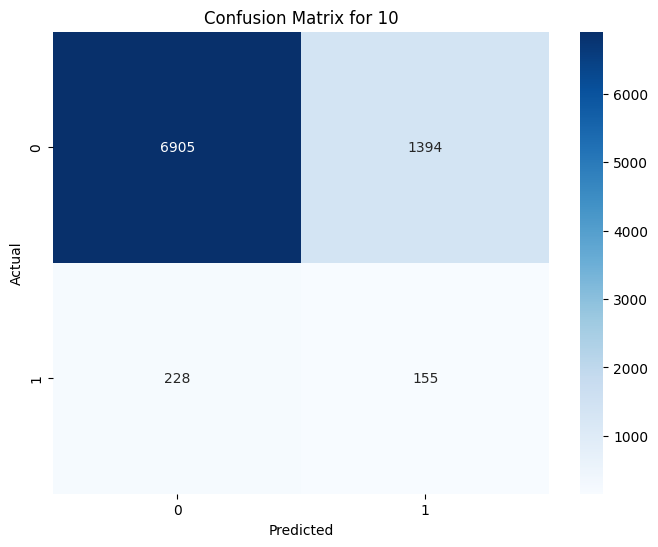

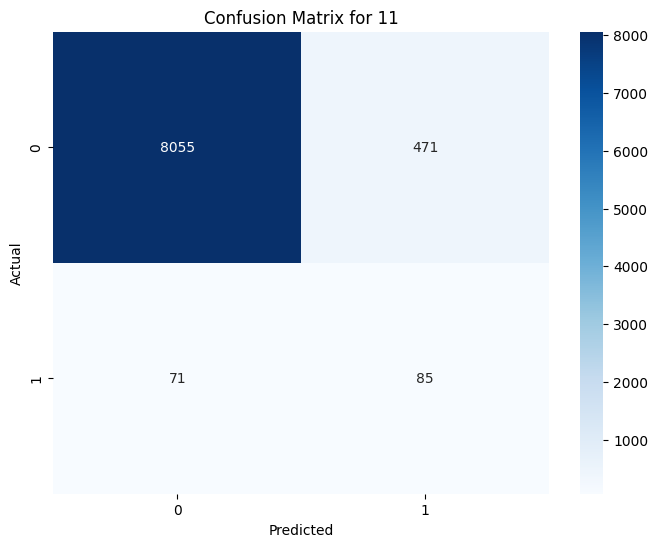

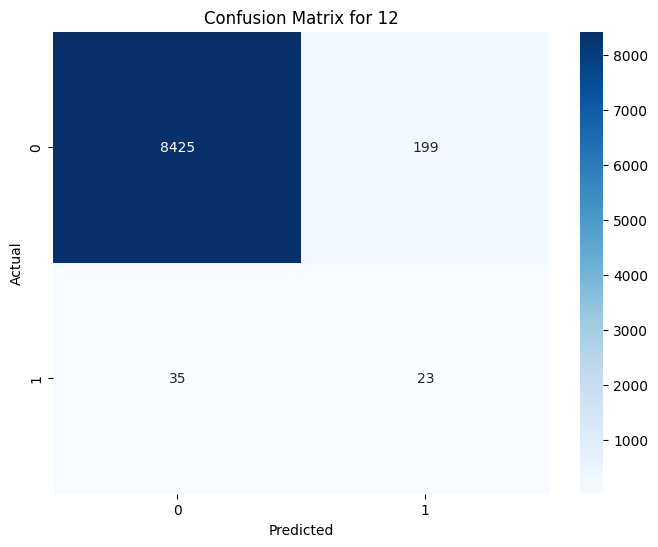

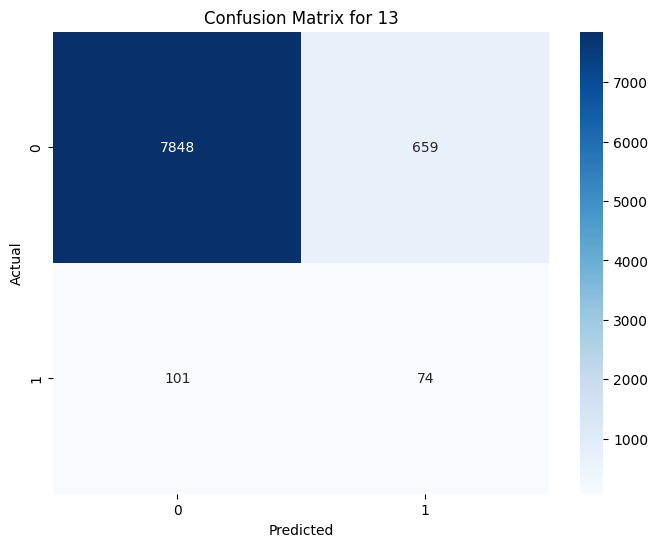

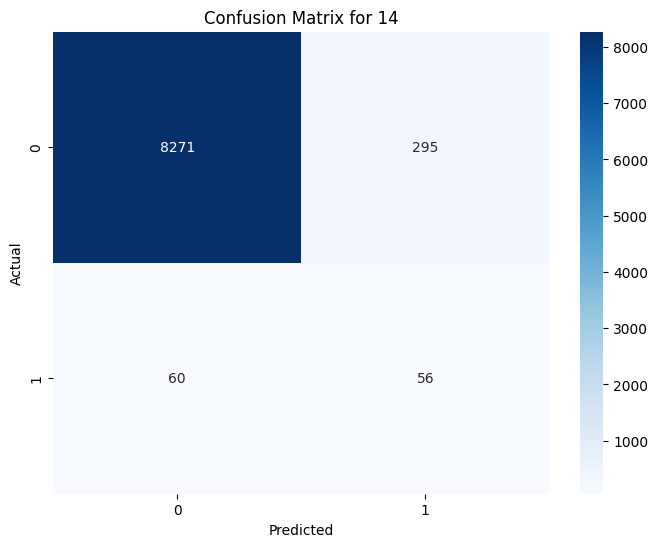

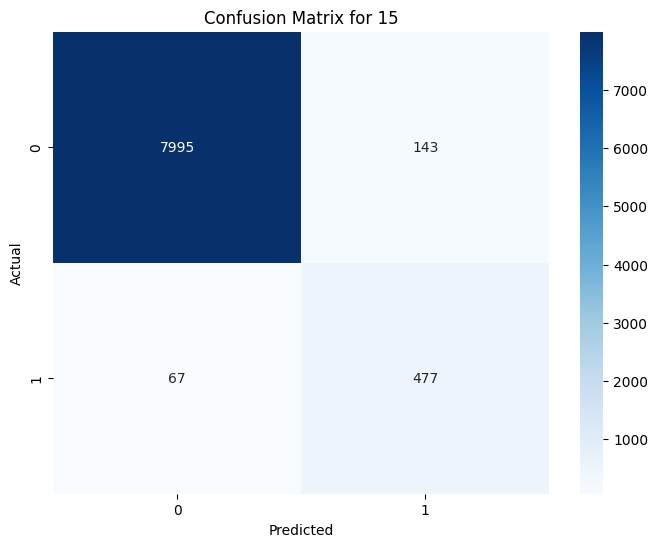

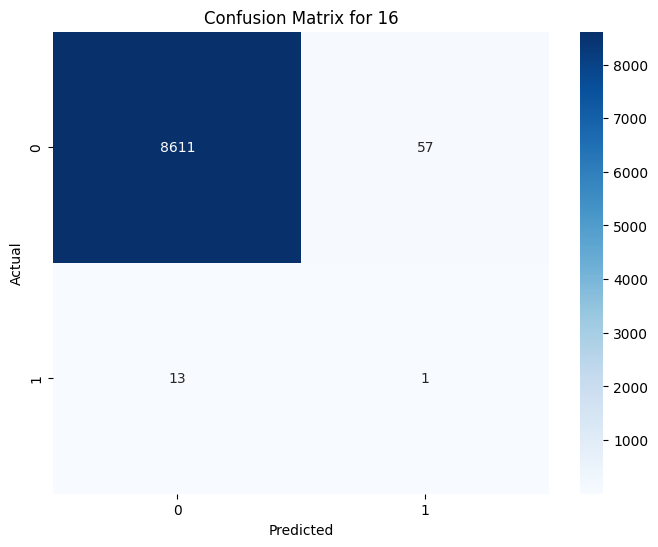

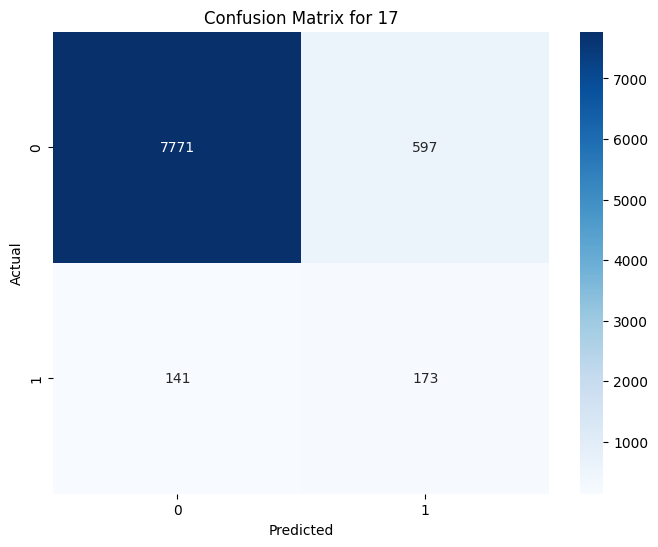

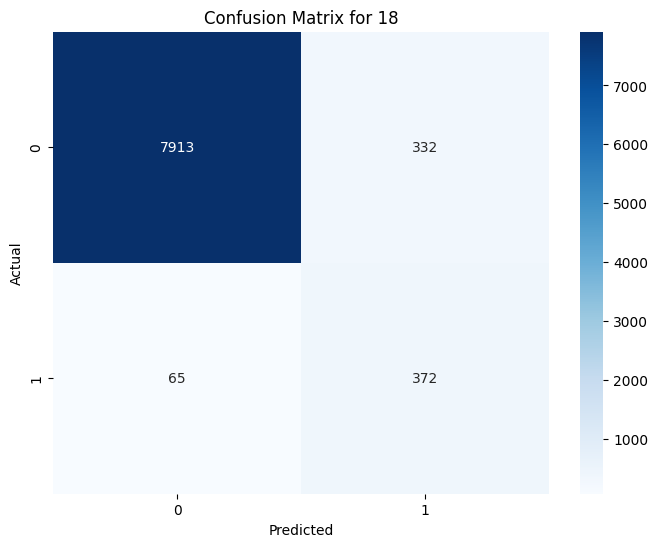

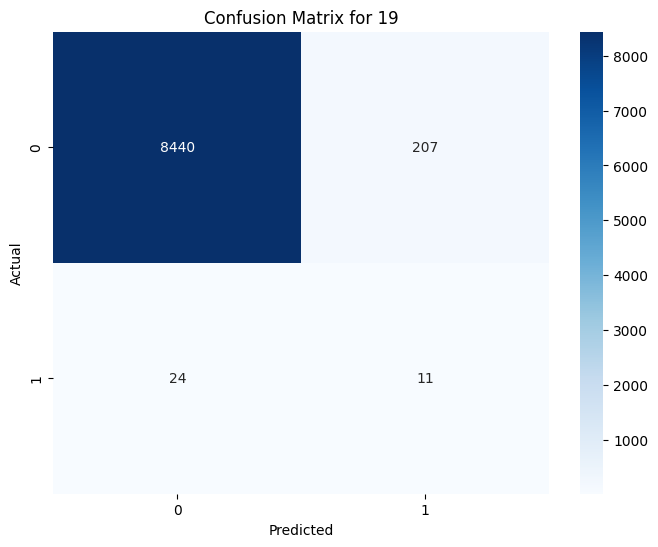

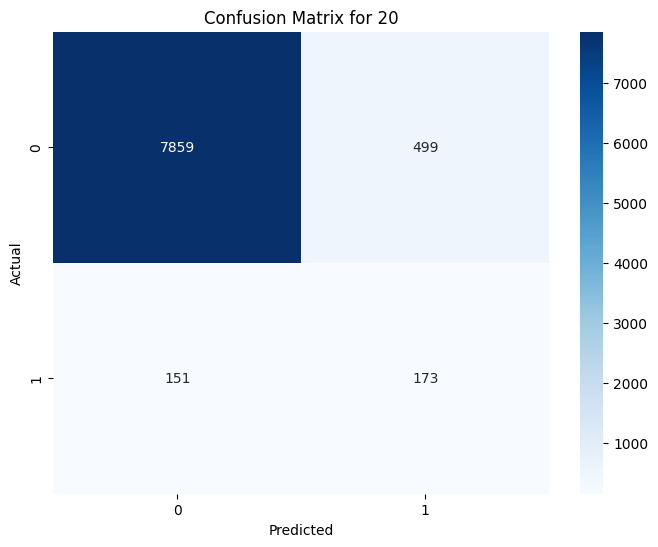

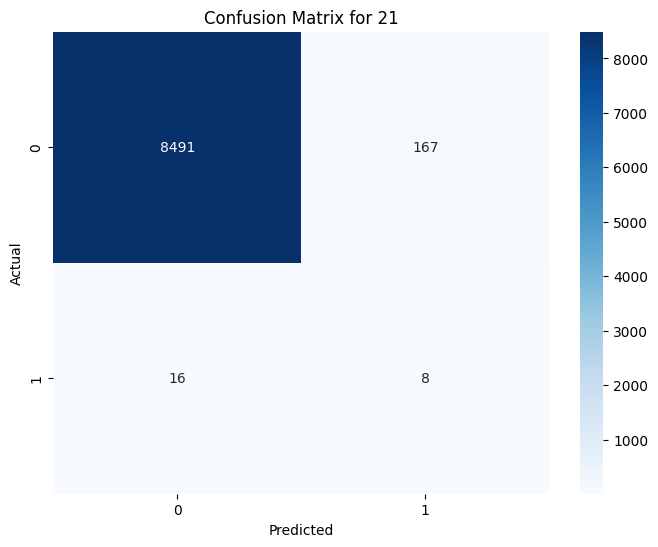

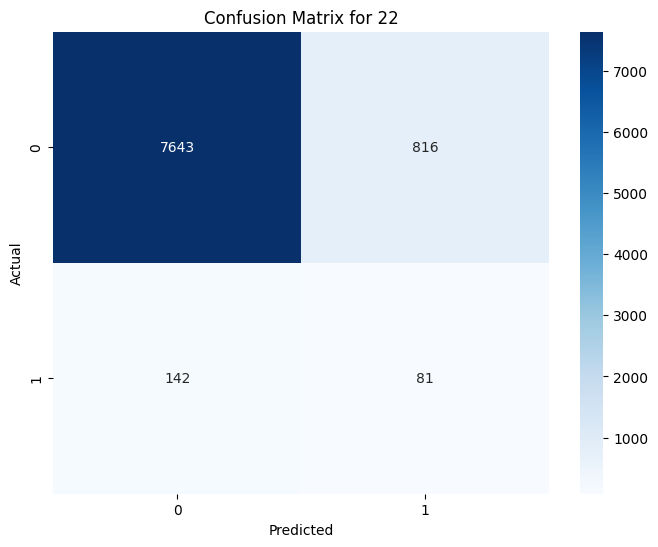

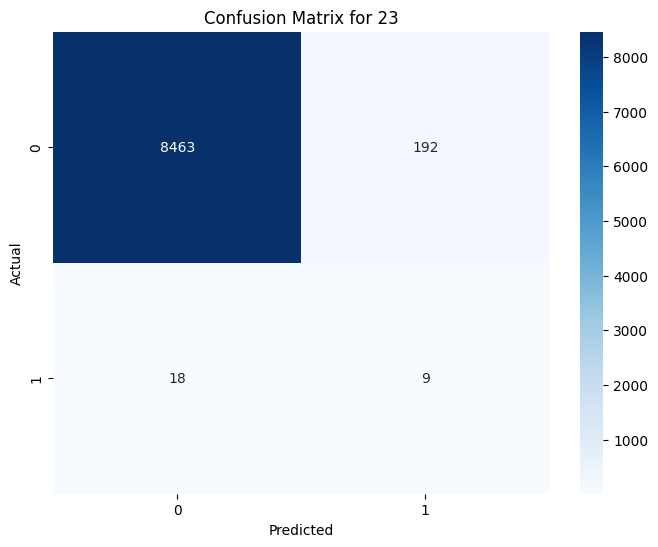

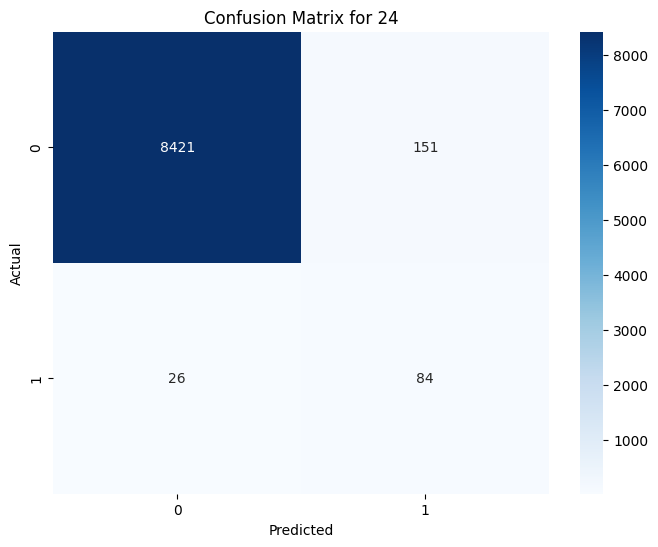

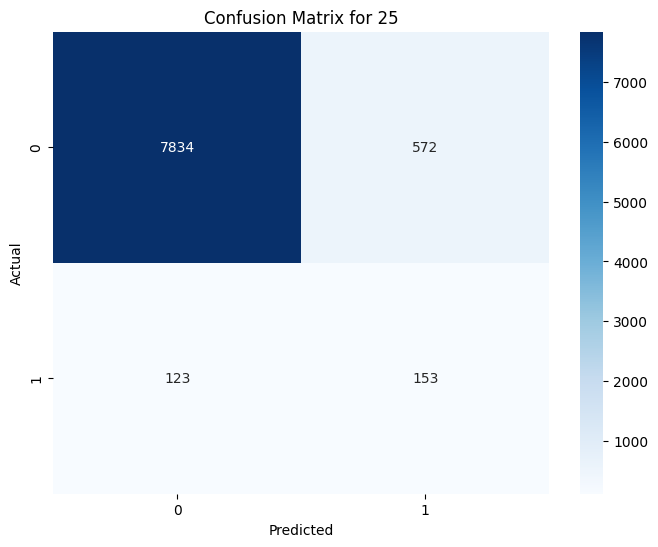

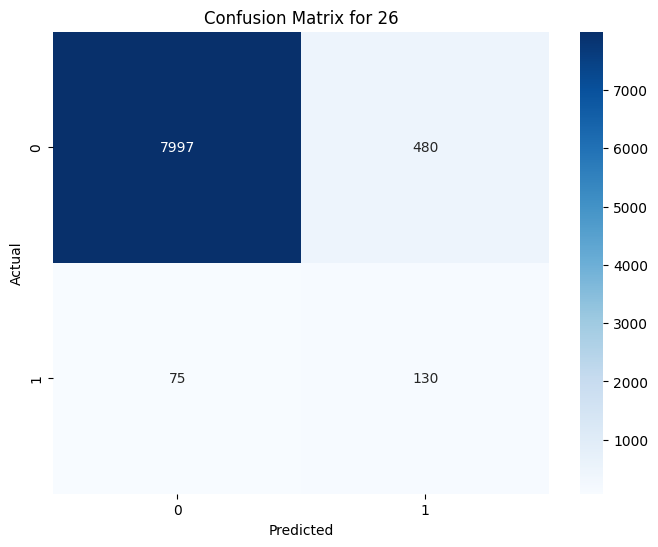

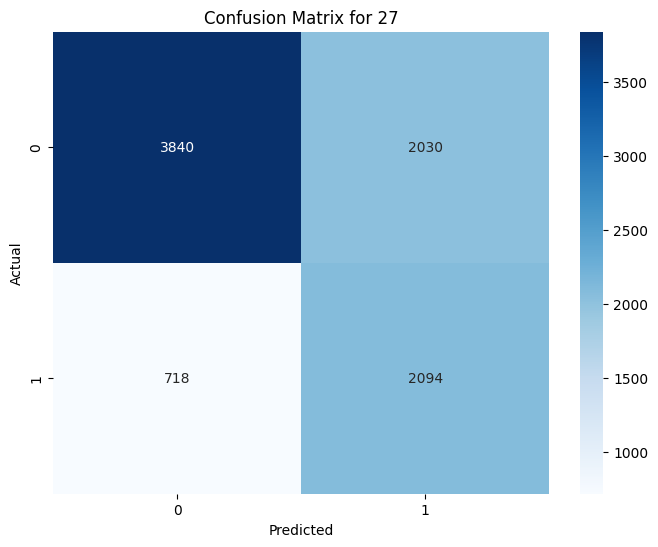

In [ ]:
# Визуализация confusion matrix для всех эмоций
confusion_mtx = multilabel_confusion_matrix(y_test_binarized, baseline_predictions)
for i, emotion in enumerate(mlb.classes_):
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_mtx[i], annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {emotion}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

Общая точность:
Большинство эмоций имеют высокую точность (accuracy), что говорит о хорошей общей производительности модели. Однако для эмоций с низкой поддержкой (support) наблюдаются проблемы.

Эмоции с высокой поддержкой:
Эмоции, такие как admiration, amusement, gratitude, neutral, показывают высокие метрики точности (precision), полноты (recall) и F1. Это говорит о том, что модель эффективно предсказывает эти категории.

Эмоции с низкой поддержкой:
Для эмоций, таких как grief, nervousness, remorse, relief, модель показывает низкие значения recall. Это может быть связано с недостаточным количеством примеров в обучающей выборке для этих категорий.

Дисбаланс классов:
Множество эмоций имеет значительный перекос в распределении (например, большое количество меток класса 0 и малое — класса 1). Это приводит к завышенной точности для класса 0 и низкой полноте для класса 1.

Наиболее проблемные эмоции:
Эмоции с F1-метрикой ниже 0.3, такие как grief, nervousness, remorse, требуют внимания. Модель с трудом распознает эти эмоции, что может быть связано с их высокой субъективностью или пересечением с другими эмоциями.

Эмоция neutral:
У этой эмоции самые сбалансированные метрики среди всех классов, что свидетельствует о том, что модель лучше распознает неэмоциональные тексты.

## Experiment 1. TF-IDF + XGBoost

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report, multilabel_confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import numpy as np

# Загрузка сохраненного объекта MultiLabelBinarizer
mlb = joblib.load('mlb.pkl')

# Бинаризация меток для train/test данных
y_train_binarized = y_train.drop(columns=['label_count']).values
y_test_binarized = y_test.drop(columns=['label_count']).values

# Преобразование текстов в TF-IDF
vectorizer_tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer_tfidf.fit_transform(X_train)
X_test_tfidf = vectorizer_tfidf.transform(X_test)

# Сохранение TF-IDF векторизатора
joblib.dump(vectorizer_tfidf, 'tfidf_vectorizer.pkl')

# Обучение модели XGBoost с использованием MultiOutputClassifier
xgb_model = XGBClassifier(eval_metric='logloss')
multi_target_xgb = MultiOutputClassifier(xgb_model)
multi_target_xgb.fit(X_train_tfidf, y_train_binarized)

# Предсказания
xgb_predictions = multi_target_xgb.predict(X_test_tfidf)

## Оценка качества, анализ ошибок

In [ ]:
# Декодируем метки из бинарного формата в исходный список меток
predicted_labels_xgb = mlb.inverse_transform(xgb_predictions)
true_labels_xgb = mlb.inverse_transform(y_test_binarized)

# Вывод первых 10 текстов и их меток
for i in range(10):
    print(f"Текст {i + 1}: {X_test.iloc[i]}")
    print(f"Предсказанные метки (XGBoost): {predicted_labels_xgb[i]}")
    print(f"Правильные метки: {true_labels_xgb[i]}")
    print("-" * 80)

Текст 1: это работает случае имя выполняет задание птичий короб видит условий контракта
Предсказанные метки (XGBoost): (27,)
Правильные метки: (27,)
--------------------------------------------------------------------------------
Текст 2: доступ должен ограничен уничтожается
Предсказанные метки (XGBoost): ()
Правильные метки: (3,)
--------------------------------------------------------------------------------
Текст 3: совершенно справедливо пытался всем напомнить это влюбляться тебе нравится
Предсказанные метки (XGBoost): ()
Правильные метки: (4,)
--------------------------------------------------------------------------------
Текст 4: полиэтиолог живу районе роли переехал сюда работе жены удивлен обнаружив людей упоминают хаха
Предсказанные метки (XGBoost): (1, 26)
Правильные метки: (26,)
--------------------------------------------------------------------------------
Текст 5: наумэн мужчинамасайнам приходится легче большинство моих асанских друзей симпатичные мальчики ебаный мальчик

In [ ]:
# Вывод метрик для каждой эмоции
for i, emotion in enumerate(mlb.classes_):
    print(f'Эмоция: {emotion}')
    print(classification_report(y_test_binarized[:, i], xgb_predictions[:, i]))

Эмоция: 0
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      7819
           1       0.74      0.31      0.44       863

    accuracy                           0.92      8682
   macro avg       0.83      0.65      0.70      8682
weighted avg       0.91      0.92      0.91      8682

Эмоция: 1
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      8229
           1       0.77      0.66      0.71       453

    accuracy                           0.97      8682
   macro avg       0.88      0.83      0.85      8682
weighted avg       0.97      0.97      0.97      8682

Эмоция: 2
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      8359
           1       0.49      0.10      0.16       323

    accuracy                           0.96      8682
   macro avg       0.73      0.55      0.57      8682
weighted avg       0.95      0.96      0.95 

In [ ]:
# Рассчитываем общую точность (accuracy)
overall_accuracy = accuracy_score(y_test_binarized, xgb_predictions)
print(f"Общая точность (accuracy): {overall_accuracy:.4f}")

Общая точность (accuracy): 0.1819


In [ ]:
# Расчет макро-усредненных метрик
precision_macro = np.mean([precision_score(y_test_binarized[:, i], xgb_predictions[:, i]) for i in range(y_test_binarized.shape[1])])
recall_macro = np.mean([recall_score(y_test_binarized[:, i], xgb_predictions[:, i]) for i in range(y_test_binarized.shape[1])])
f1_macro = np.mean([f1_score(y_test_binarized[:, i], xgb_predictions[:, i]) for i in range(y_test_binarized.shape[1])])

print(f"Макро-усредненная точность (precision): {precision_macro:.4f}")
print(f"Макро-усредненная полнота (recall): {recall_macro:.4f}")
print(f"Макро-усредненный F1-скор: {f1_macro:.4f}")

Макро-усредненная точность (precision): 0.5730
Макро-усредненная полнота (recall): 0.1868
Макро-усредненный F1-скор: 0.2498


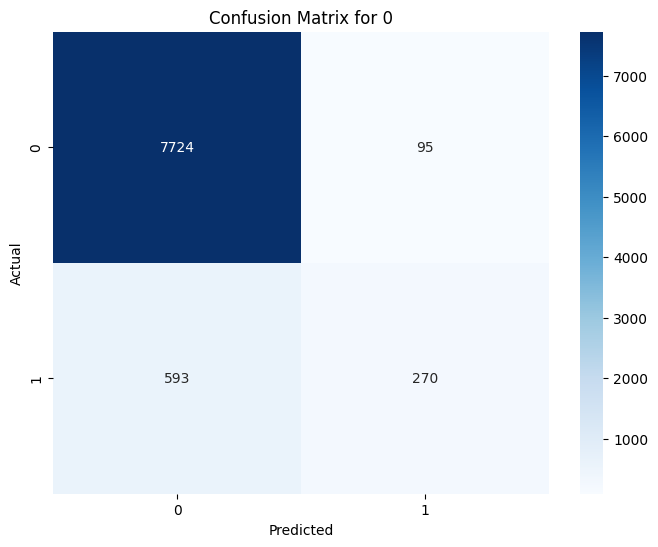

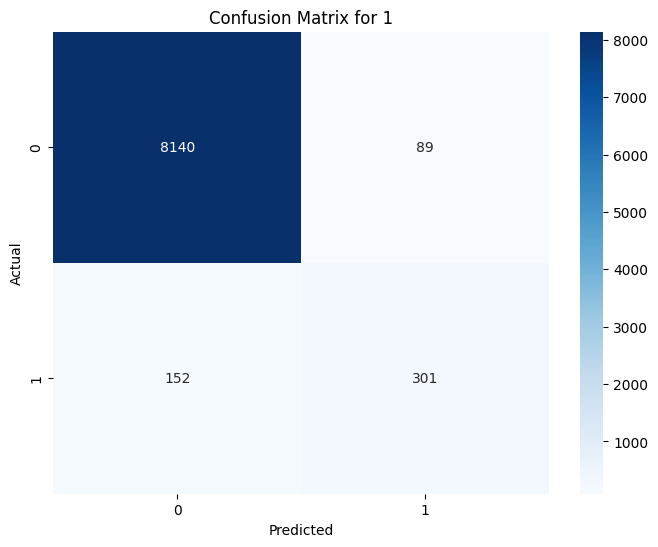

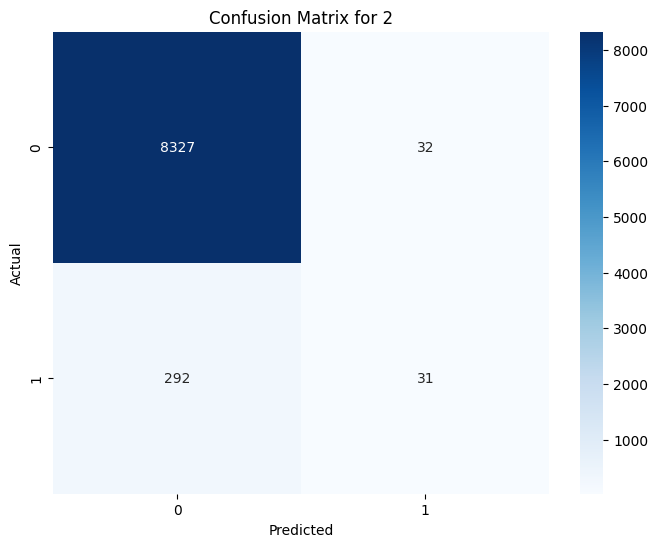

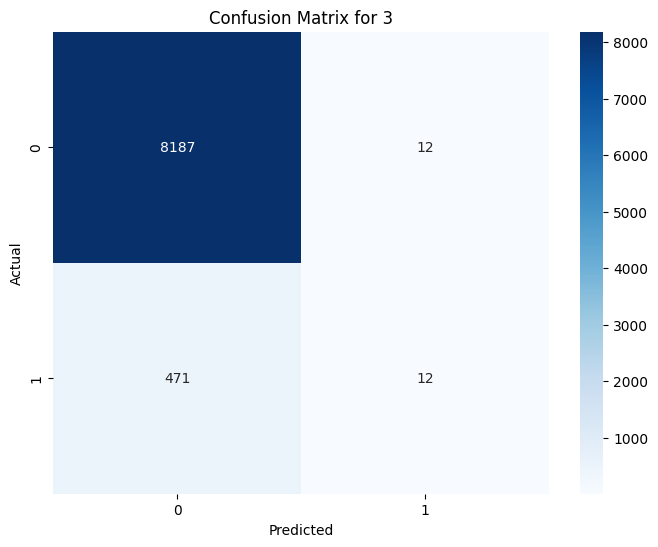

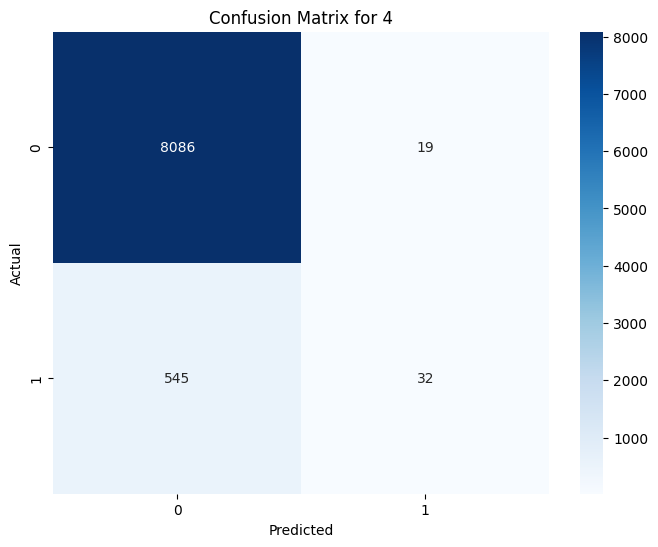

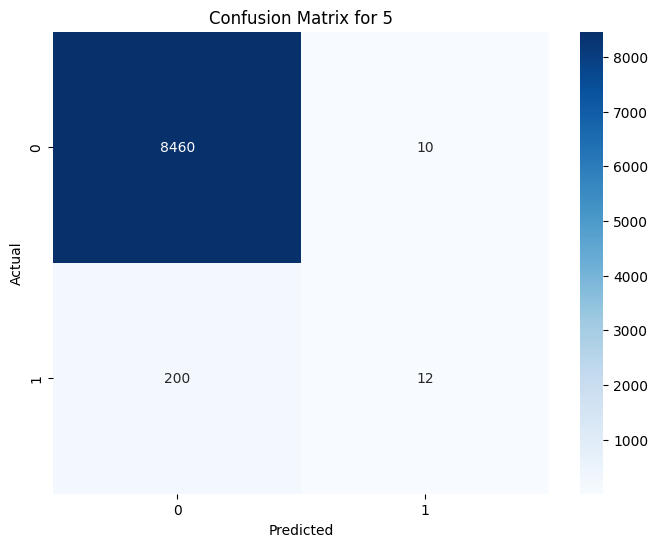

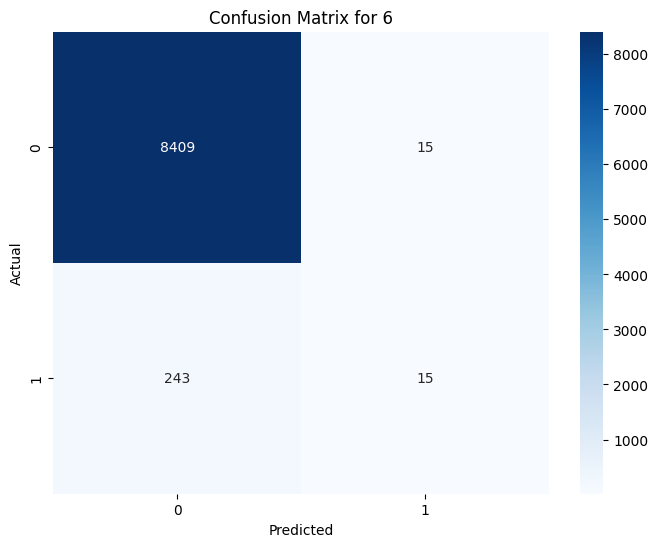

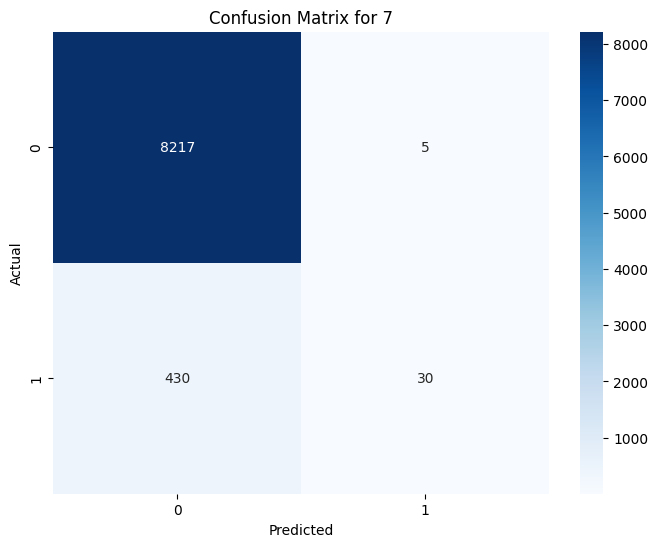

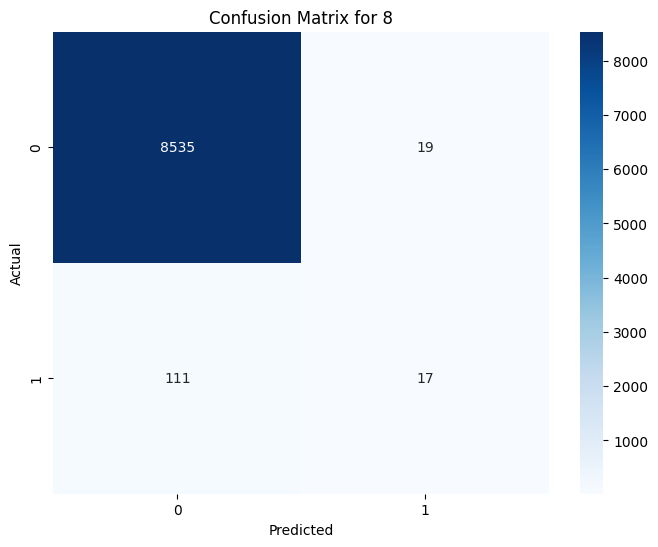

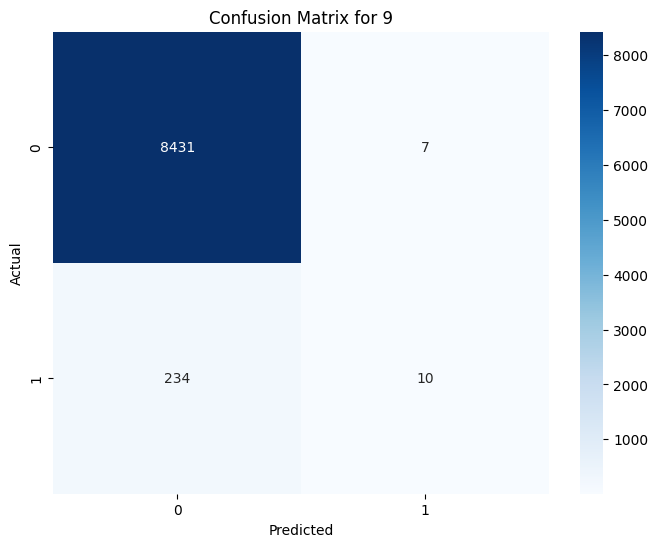

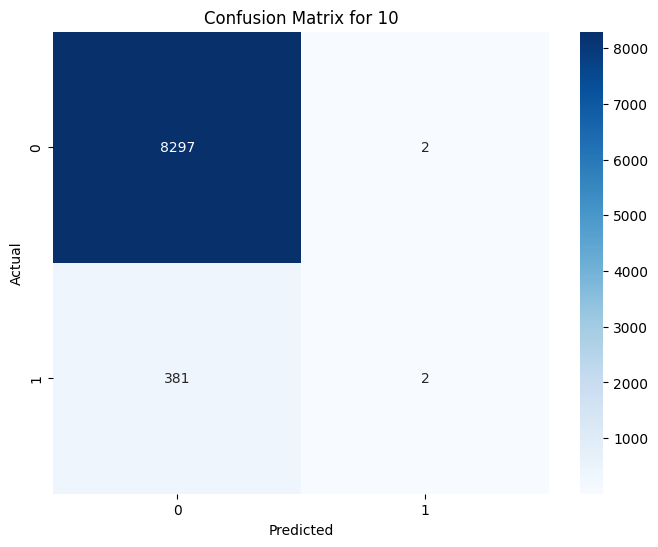

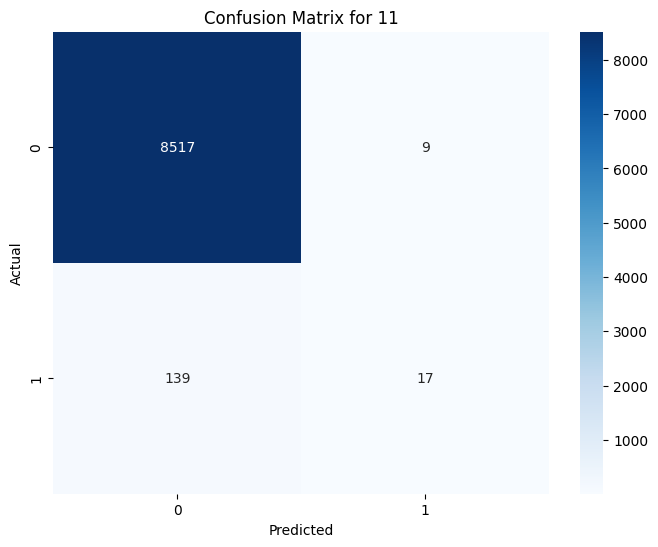

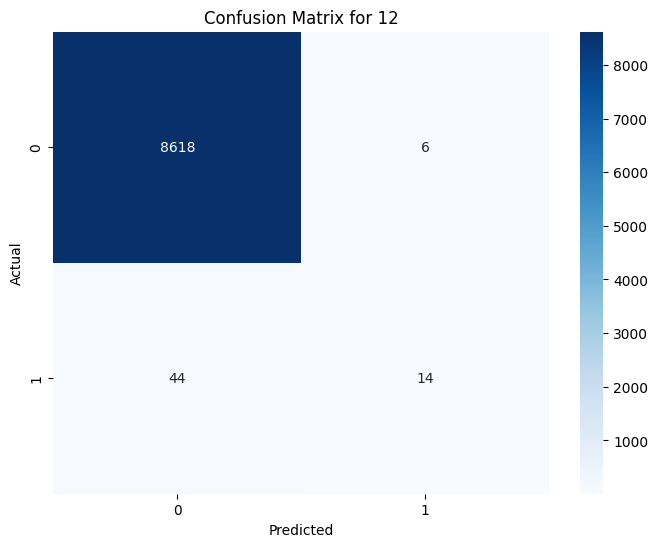

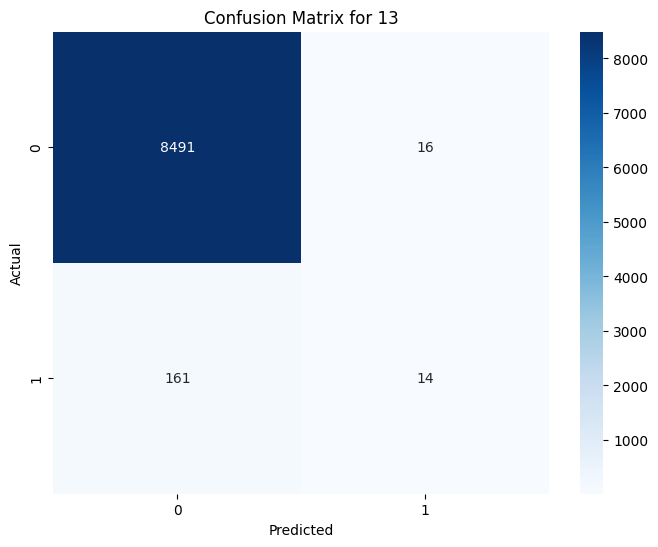

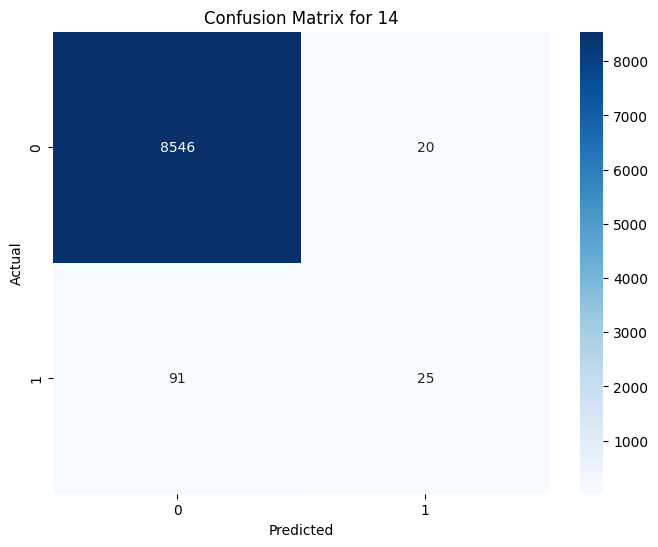

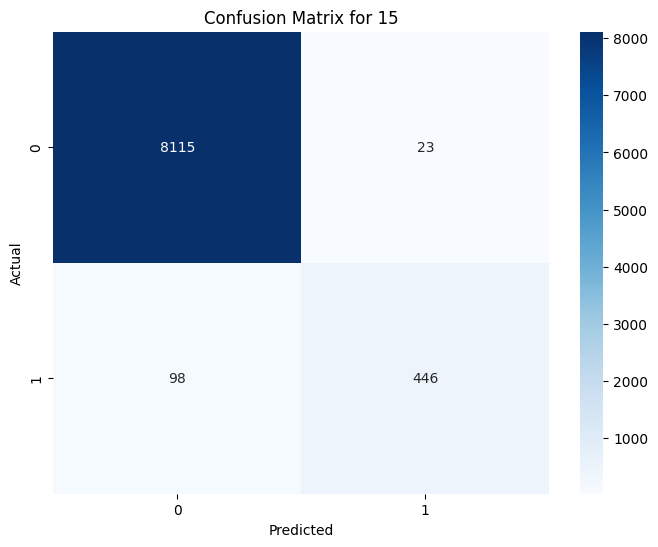

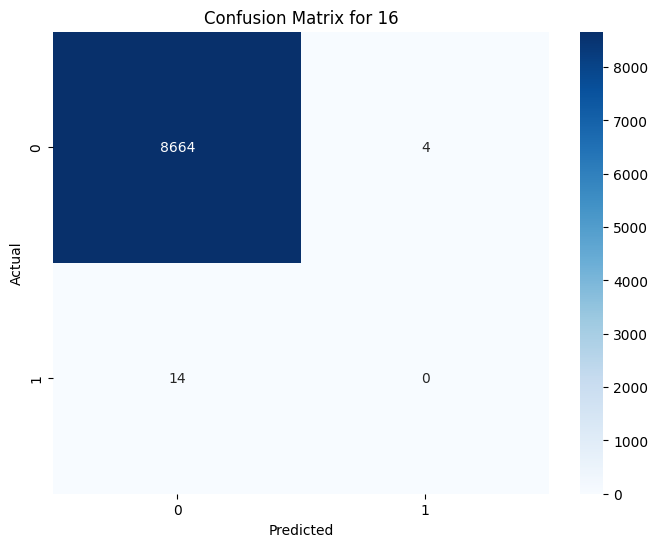

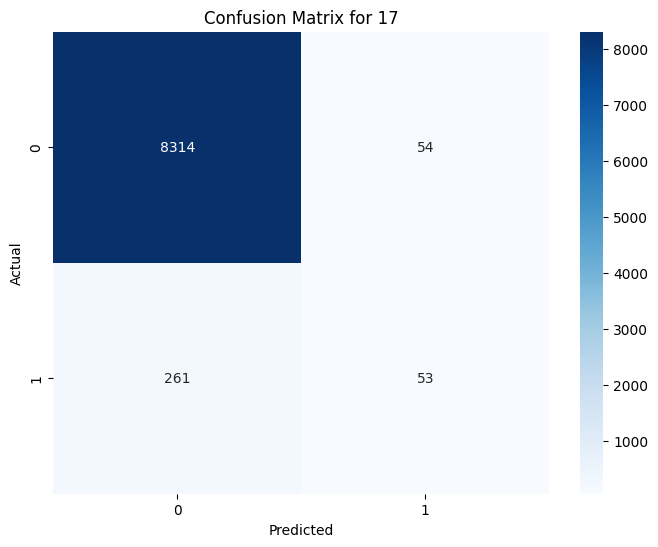

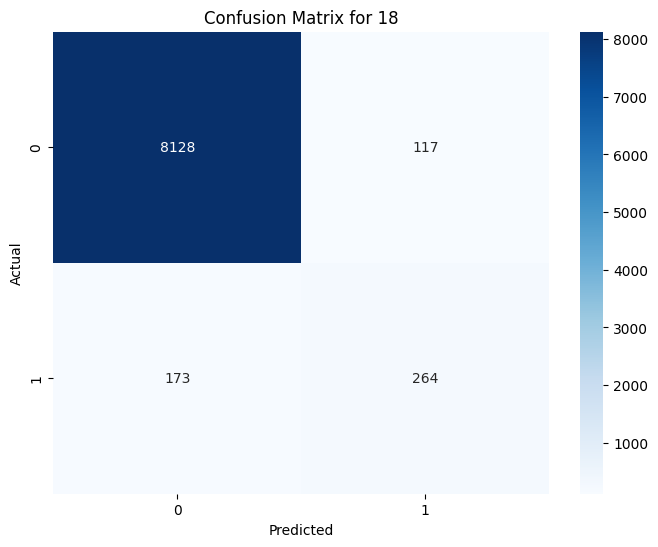

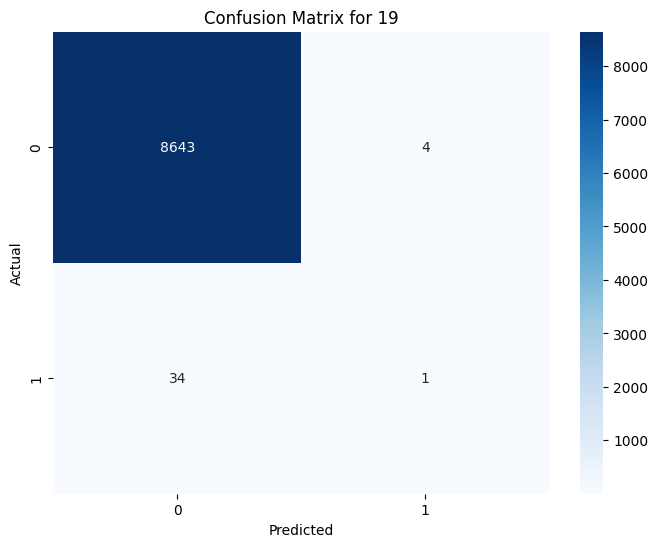

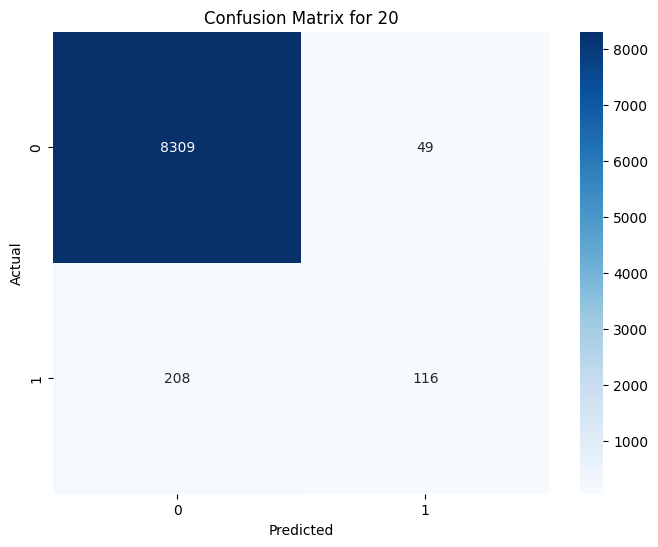

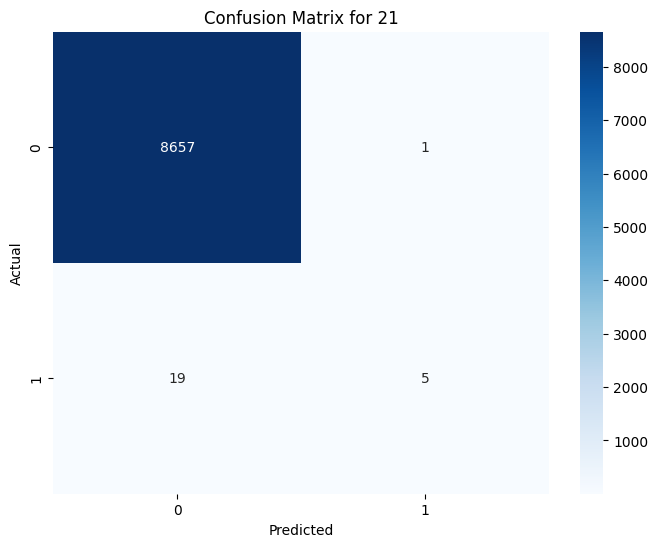

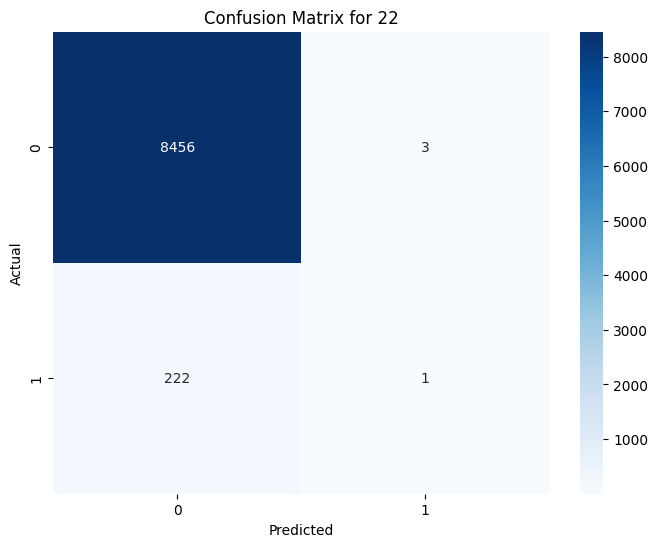

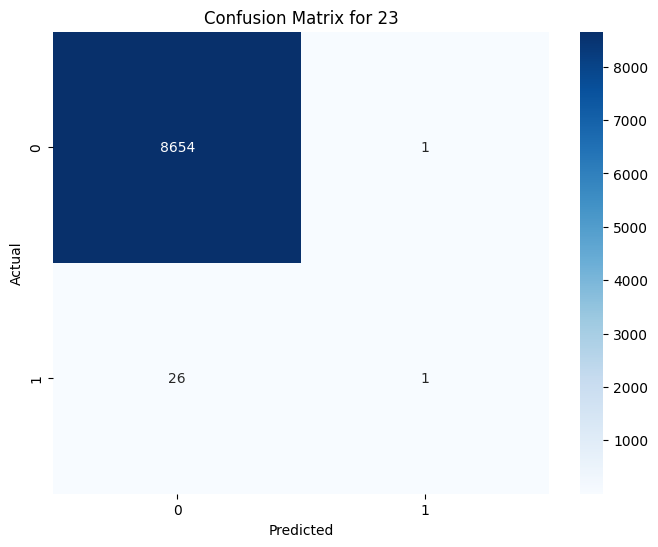

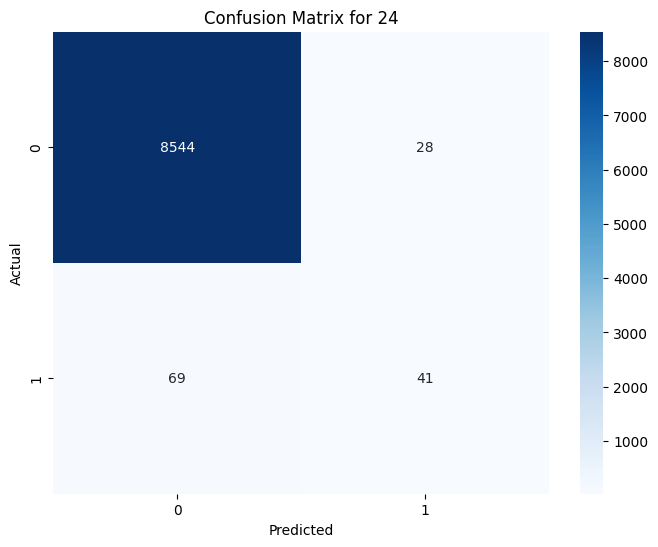

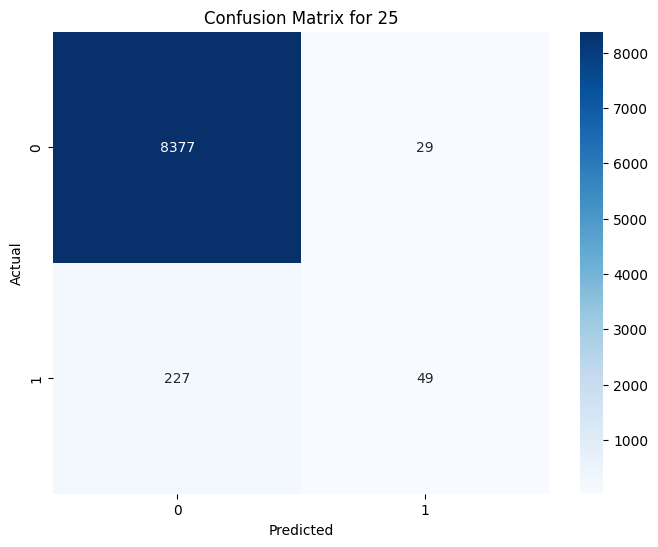

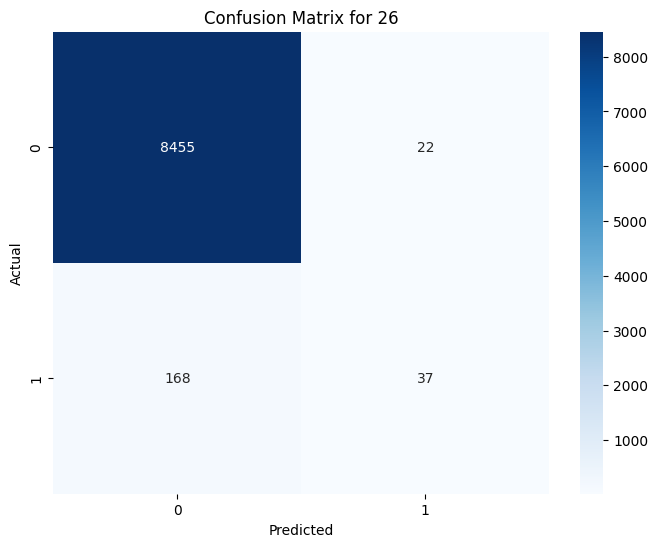

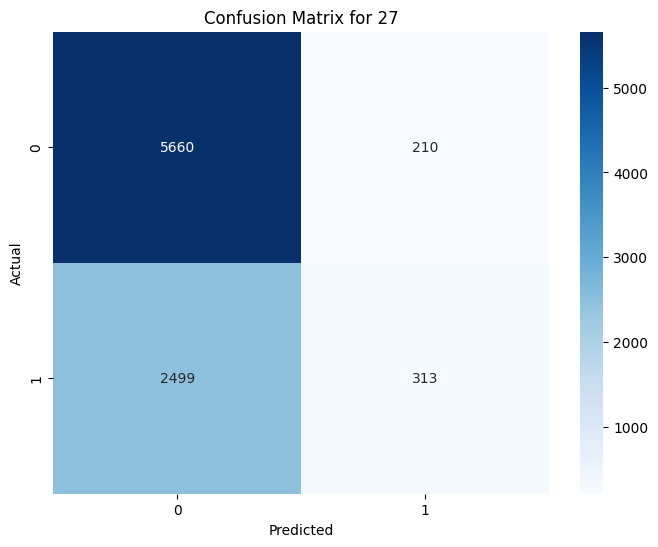

In [ ]:
# Визуализация confusion matrix для всех эмоций
confusion_mtx = multilabel_confusion_matrix(y_test_binarized, xgb_predictions)
for i, emotion in enumerate(mlb.classes_):
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_mtx[i], annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {emotion}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

Общая точность:
Модель демонстрирует высокую точность для большинства эмоций, особенно для случаев, где текст относится к категории neutral или отсутствия определённой эмоции. Однако для категорий с малым числом положительных примеров наблюдается низкая полнота и, как следствие, слабая F1-метрика.

Эмоции с высокой поддержкой:
Эмоции: admiration, amusement, approval, caring, disapproval, disgust, neutral
Для этих эмоций модель демонстрирует отличную точность и полноту для отрицательных примеров, с F1-метрикой выше 0.95.
Пример: Для amusement точность (precision) класса 0 составляет 0.98, а F1 — 0.99.

Низкий recall для положительного класса:
Для эмоций anger, annoyance, curiosity, disappointment, excitement, fear, remorse, полнота класса 1 находится на уровне ниже 0.10, что приводит к низким F1-метрикам (ниже 0.15).

Это говорит о сложности модели различать тонкие эмоциональные оттенки или о недостатке данных для обучения.
Пример: Для annoyance полнота положительного класса составляет всего 0.02, что даёт F1-метрику 0.05.
Редкие эмоции с критически низкими результатами:

grief, nervousness, relief: Эти эмоции имеют крайне низкую полноту (recall) положительного класса, что указывает на нехватку данных для обучения или их размытость в контексте.
Пример: Для grief полнота класса 1 равна 0.00, а точность близка к нулю.
Эмоция: neutral
Эта категория имеет самый заметный перекос данных (5870 отрицательных примеров против 2812 положительных). Recall для положительного класса равен всего 0.11, что значительно снижает F1-метрику до 0.19.

Дисбаланс классов:
Большинство эмоций характеризуются значительным перевесом отрицательного класса. Это приводит к:
Высокой точности для класса 0.
Низкой полноте для класса 1.
Пример: Для disappointment, полнота положительного класса составляет всего 0.04, несмотря на точность класса 0 (0.97).

Наиболее проблемные эмоции

Эмоции с F1-метрикой для положительного класса ниже 0.3:

anger, annoyance, curiosity, excitement, fear, grief, nervousness, relief, sadness, surprise.
Эти категории требуют внимания, так как модель с трудом распознаёт тексты с соответствующими эмоциями.

## Experiment 2. Transformers - RuBERT

In [ ]:
import numpy as np
import tensorflow as tf
from transformers import TFBertModel, BertTokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from datasets import load_dataset

# Загрузка датасета
dataset = load_dataset("seara/ru_go_emotions", "simplified")

# Инициализация токенизатора
tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased')

# Функция для токенизации текстов
def tokenize_texts(texts, tokenizer, max_length=128):
    encodings = tokenizer(
        list(texts),
        truncation=True,
        padding='max_length',  # гарантирует, что все тексты будут длины max_length
        max_length=max_length,
        return_tensors='np'
    )
    return encodings['input_ids'], encodings['attention_mask']

# Токенизация данных
train_texts = dataset['train']['ru_text']
val_texts = dataset['validation']['ru_text']
test_texts = dataset['test']['ru_text']

train_input_ids, train_attention_masks = tokenize_texts(train_texts, tokenizer)
val_input_ids, val_attention_masks = tokenize_texts(val_texts, tokenizer)
test_input_ids, test_attention_masks = tokenize_texts(test_texts, tokenizer)

# Подготовка меток (бинаризация)
mlb = MultiLabelBinarizer()
train_labels = mlb.fit_transform(dataset['train']['labels'])
val_labels = mlb.transform(dataset['validation']['labels'])
test_labels = mlb.transform(dataset['test']['labels'])

# Проверка данных
print(f"[DEBUG] Train shape: input_ids={train_input_ids.shape}, labels={train_labels.shape}")
print(f"[DEBUG] Validation shape: input_ids={val_input_ids.shape}, labels={val_labels.shape}")

README.md:   0%|          | 0.00/5.25k [00:00<?, ?B/s]

(…)-00000-of-00001-46692d7e0c0147a4.parquet:   0%|          | 0.00/6.10M [00:00<?, ?B/s]

(…)-00000-of-00001-9e6cdf9c1f2a20a4.parquet:   0%|          | 0.00/767k [00:00<?, ?B/s]

(…)-00000-of-00001-0acb4be83ca6567e.parquet:   0%|          | 0.00/761k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


[DEBUG] Train shape: input_ids=(43410, 128), labels=(43410, 28)
[DEBUG] Validation shape: input_ids=(5426, 128), labels=(5426, 28)


## Подбор параметров

In [ ]:
import tensorflow as tf
import gc  # Для ручного вызова сборщика мусора
from transformers import TFBertModel
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm  # Импортируем tqdm для отображения прогресса

# Класс, который оборачивает BERT модель в слой Keras
class BertLayer(tf.keras.layers.Layer):
    def __init__(self, model_name):
        super(BertLayer, self).__init__()
        # Загружаем модель BERT
        self.bert_model = TFBertModel.from_pretrained(model_name, from_pt=True)

    def call(self, inputs):
        input_ids, attention_mask = inputs
        # Прямой вызов BERT на входных данных
        bert_output = self.bert_model([input_ids, attention_mask])[0]  # Получаем выход из BERT
        return bert_output

# Функция для создания модели с Keras
def create_model(dropout_rate, learning_rate, input_shape, num_labels):
    # Входные данные для BERT
    input_ids = tf.keras.Input(shape=(input_shape,), dtype=tf.int32, name="input_ids")
    attention_mask = tf.keras.Input(shape=(input_shape,), dtype=tf.int32, name="attention_mask")

    # Используем кастомный слой для BERT
    bert_layer = BertLayer('DeepPavlov/rubert-base-cased')
    bert_output = bert_layer([input_ids, attention_mask])  # Выход из кастомного слоя

    # Выбираем только первый токен [CLS] для классификации
    cls_token_output = bert_output[:, 0, :]

    # Dropout
    dropped_output = tf.keras.layers.Dropout(rate=dropout_rate)(cls_token_output)

    # Выходной слой
    output = tf.keras.layers.Dense(num_labels, activation='sigmoid')(dropped_output)

    model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

    return model

# Извлекаем 5% данных для обучения
sample_size = int(0.05 * len(train_input_ids))

# Используем случайную выборку 5% данных для обучения
X_train_sampled, X_val, y_train_sampled, y_val = train_test_split(
    list(zip(train_input_ids, train_attention_masks)), train_labels, train_size=sample_size, random_state=42
)

# Используем случайную выборку 5% для валидации
X_val_sampled, X_val_final, y_val_sampled, y_val_final = train_test_split(
    list(zip(X_val_input_ids, X_val_attention_masks)), y_val, train_size=sample_size, random_state=42
)

# Подбор гиперпараметров с GridSearch
param_grid = {
    'dropout_rate': [0.1, 0.2, 0.3, 0.4],
    'learning_rate': [1e-5, 2e-5, 3e-5, 5e-5]
}

# Список для сохранения моделей и их результатов
results = []

# Преобразуем данные для обучения и валидации
X_train_input_ids = np.array([x[0] for x in X_train_sampled])
X_train_attention_masks = np.array([x[1] for x in X_train_sampled])
X_val_input_ids = np.array([x[0] for x in X_val_sampled])
X_val_attention_masks = np.array([x[1] for x in X_val_sampled])

best_model = None
best_score = -1
best_params = {}

# Процесс перебора гиперпараметров
for dropout_rate in tqdm(param_grid['dropout_rate'], desc="Dropout rates", leave=False):
    for learning_rate in tqdm(param_grid['learning_rate'], desc="Learning rates", leave=False):
        print(f"Testing model with dropout_rate={dropout_rate} and learning_rate={learning_rate}")

        # Создание модели с текущими гиперпараметрами
        model = create_model(dropout_rate, learning_rate, input_shape=128, num_labels=y_train_sampled.shape[1])

        # Компиляция модели
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                      loss=tf.keras.losses.BinaryCrossentropy(),
                      metrics=['accuracy'])

        # Обучение модели
        model.fit(
            [X_train_input_ids, X_train_attention_masks],
            y_train_sampled,
            batch_size=16,
            epochs=1,
            validation_data=([X_val_input_ids, X_val_attention_masks], y_val_sampled)
        )

        # Оценка модели на валидационных данных
        val_loss, val_acc = model.evaluate([X_val_input_ids, X_val_attention_masks], y_val_sampled)
        print(f"Validation Accuracy: {val_acc}")

        if val_acc > best_score:
            best_score = val_acc
            best_model = model
            best_params = {'dropout_rate': dropout_rate, 'learning_rate': learning_rate}

        # Очистка памяти после каждой модели
        del model
        tf.keras.backend.clear_session()  # Очистка графа TensorFlow
        gc.collect()  # Сборка мусора

# Вывод лучших гиперпараметров
print(f"Лучший dropout_rate: {best_params['dropout_rate']}")
print(f"Лучшая learning_rate: {best_params['learning_rate']}")

Learning rates:   0%|          | 0/4 [00:00<?, ?it/s]

Testing model with dropout_rate=0.1 and learning_rate=1e-05


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.decoder.weight', 'bert.embeddings.position_ids', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the 

68/68 [==============================] - 26s 375ms/step - loss: 0.1388 - accuracy: 0.3286



Learning rates:  25%|██▌       | 1/4 [02:33<07:40, 153.34s/it]

Validation Accuracy: 0.3285714387893677
Testing model with dropout_rate=0.1 and learning_rate=2e-05


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.decoder.weight', 'bert.embeddings.position_ids', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the 

68/68 [==============================] - 26s 376ms/step - loss: 0.1323 - accuracy: 0.3622



Learning rates:  50%|█████     | 2/4 [05:06<05:06, 153.46s/it]

Validation Accuracy: 0.3622119724750519
Testing model with dropout_rate=0.1 and learning_rate=3e-05


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.decoder.weight', 'bert.embeddings.position_ids', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the 

68/68 [==============================] - 26s 375ms/step - loss: 0.1352 - accuracy: 0.3705



Learning rates:  75%|███████▌  | 3/4 [07:39<02:33, 153.29s/it]

Validation Accuracy: 0.3705069124698639
Testing model with dropout_rate=0.1 and learning_rate=5e-05


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.decoder.weight', 'bert.embeddings.position_ids', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the 

68/68 [==============================] - 26s 376ms/step - loss: 0.1303 - accuracy: 0.3972



Dropout rates:  25%|██▌       | 1/4 [10:14<30:44, 614.72s/it] 

Validation Accuracy: 0.39723503589630127



Learning rates:   0%|          | 0/4 [00:00<?, ?it/s]

Testing model with dropout_rate=0.2 and learning_rate=1e-05


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.decoder.weight', 'bert.embeddings.position_ids', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the 

68/68 [==============================] - 25s 374ms/step - loss: 0.1397 - accuracy: 0.3406



Learning rates:  25%|██▌       | 1/4 [02:33<07:41, 153.93s/it]

Validation Accuracy: 0.3405529856681824
Testing model with dropout_rate=0.2 and learning_rate=2e-05


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.decoder.weight', 'bert.embeddings.position_ids', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the 

68/68 [==============================] - 26s 377ms/step - loss: 0.1383 - accuracy: 0.3424



Learning rates:  50%|█████     | 2/4 [05:08<05:08, 154.22s/it]

Validation Accuracy: 0.3423963189125061
Testing model with dropout_rate=0.2 and learning_rate=3e-05


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.decoder.weight', 'bert.embeddings.position_ids', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the 

68/68 [==============================] - 26s 376ms/step - loss: 0.1258 - accuracy: 0.3968



Learning rates:  75%|███████▌  | 3/4 [07:40<02:33, 153.33s/it]

Validation Accuracy: 0.39677420258522034
Testing model with dropout_rate=0.2 and learning_rate=5e-05


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.decoder.weight', 'bert.embeddings.position_ids', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the 

68/68 [==============================] - 26s 378ms/step - loss: 0.1348 - accuracy: 0.3535



Dropout rates:  50%|█████     | 2/4 [20:30<20:30, 615.34s/it] 

Validation Accuracy: 0.3534562289714813



Learning rates:   0%|          | 0/4 [00:00<?, ?it/s]

Testing model with dropout_rate=0.3 and learning_rate=1e-05


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.decoder.weight', 'bert.embeddings.position_ids', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the 

68/68 [==============================] - 25s 375ms/step - loss: 0.1402 - accuracy: 0.3180



Learning rates:  25%|██▌       | 1/4 [02:35<07:47, 155.68s/it]

Validation Accuracy: 0.3179723620414734
Testing model with dropout_rate=0.3 and learning_rate=2e-05


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.decoder.weight', 'bert.embeddings.position_ids', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the 

68/68 [==============================] - 26s 376ms/step - loss: 0.1376 - accuracy: 0.3502



Learning rates:  50%|█████     | 2/4 [05:11<05:11, 155.65s/it]

Validation Accuracy: 0.3502304255962372
Testing model with dropout_rate=0.3 and learning_rate=3e-05


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.decoder.weight', 'bert.embeddings.position_ids', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the 

68/68 [==============================] - 26s 375ms/step - loss: 0.1300 - accuracy: 0.3853



Learning rates:  75%|███████▌  | 3/4 [07:44<02:34, 154.44s/it]

Validation Accuracy: 0.3852534592151642
Testing model with dropout_rate=0.3 and learning_rate=5e-05


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.decoder.weight', 'bert.embeddings.position_ids', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the 

68/68 [==============================] - 26s 376ms/step - loss: 0.1239 - accuracy: 0.4041



Dropout rates:  75%|███████▌  | 3/4 [30:50<10:17, 617.36s/it] 

Validation Accuracy: 0.4041474759578705



Learning rates:   0%|          | 0/4 [00:00<?, ?it/s]

Testing model with dropout_rate=0.4 and learning_rate=1e-05


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.decoder.weight', 'bert.embeddings.position_ids', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the 

68/68 [==============================] - 26s 379ms/step - loss: 0.1443 - accuracy: 0.3244



Learning rates:  25%|██▌       | 1/4 [02:36<07:48, 156.22s/it]

Validation Accuracy: 0.32442396879196167
Testing model with dropout_rate=0.4 and learning_rate=2e-05


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.decoder.weight', 'bert.embeddings.position_ids', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the 

68/68 [==============================] - 25s 374ms/step - loss: 0.1357 - accuracy: 0.3714



Learning rates:  50%|█████     | 2/4 [05:11<05:11, 155.96s/it]

Validation Accuracy: 0.37142857909202576
Testing model with dropout_rate=0.4 and learning_rate=3e-05


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.decoder.weight', 'bert.embeddings.position_ids', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the 

68/68 [==============================] - 26s 375ms/step - loss: 0.1311 - accuracy: 0.3558



Learning rates:  75%|███████▌  | 3/4 [07:45<02:34, 154.76s/it]

Validation Accuracy: 0.3557603657245636
Testing model with dropout_rate=0.4 and learning_rate=5e-05


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.decoder.weight', 'bert.embeddings.position_ids', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the 

68/68 [==============================] - 25s 371ms/step - loss: 0.1298 - accuracy: 0.3963



Learning rates: 100%|██████████| 4/4 [10:20<00:00, 154.77s/it]
                                                              

Validation Accuracy: 0.3963133692741394
Лучший dropout_rate: 0.3
Лучшая learning_rate: 5e-05


## Построение лучшей модели

In [ ]:
import tensorflow as tf
from transformers import TFBertModel
import gc
import numpy as np

# Класс, который оборачивает BERT модель в слой Keras
class BertLayer(tf.keras.layers.Layer):
    def __init__(self, model_name):
        super(BertLayer, self).__init__()
        # Загружаем модель BERT с параметром from_pt=True для работы с PyTorch весами
        self.bert_model = TFBertModel.from_pretrained(model_name, from_pt=True)

    def call(self, inputs):
        input_ids, attention_mask = inputs
        # Прямой вызов BERT на входных данных
        bert_output = self.bert_model([input_ids, attention_mask])[0]  # Получаем выход из BERT
        return bert_output

# Функция для создания финальной модели с Keras
def build_final_model(dropout_rate, learning_rate, input_shape, num_labels):
    # Входные данные для BERT
    input_ids = tf.keras.Input(shape=(input_shape,), dtype=tf.int32, name="input_ids")
    attention_mask = tf.keras.Input(shape=(input_shape,), dtype=tf.int32, name="attention_mask")

    # Используем кастомный слой для BERT
    bert_layer = BertLayer('DeepPavlov/rubert-base-cased')
    bert_output = bert_layer([input_ids, attention_mask])  # Выход из кастомного слоя

    # Выбираем только первый токен [CLS] для классификации
    cls_token_output = bert_output[:, 0, :]

    # Dropout
    dropped_output = tf.keras.layers.Dropout(rate=dropout_rate)(cls_token_output)

    # Выходной слой
    output = tf.keras.layers.Dense(num_labels, activation='sigmoid')(dropped_output)

    # Создание модели
    model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

    # Компиляция модели
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Кастомный колбэк для очистки памяти между эпохами
class MemoryCleanupCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Освобождаем память в конце каждой эпохи
        gc.collect()  # Сбор мусора
        tf.keras.backend.clear_session()  # Очистка GPU памяти

# Строим финальную модель
final_model = build_final_model(
    dropout_rate=0.3,
    learning_rate=5e-05,
    input_shape=128,  # max_length = 128
    num_labels=train_labels.shape[1]  # Число классов
)

# Обучение модели
final_model.fit(
    {'input_ids': np.array(train_input_ids), 'attention_mask': np.array(train_attention_masks)},
    np.array(train_labels),
    validation_data=(
        {'input_ids': np.array(val_input_ids), 'attention_mask': np.array(val_attention_masks)},
        np.array(val_labels)
    ),
    batch_size=16,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2),
        MemoryCleanupCallback()  # Добавляем кастомный колбэк для очистки памяти
    ]
)

pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'bert.embeddings.position_ids', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the 

Epoch 1/5
2714/2714 [==============================] - 1313s 471ms/step - loss: 0.1119 - accuracy: 0.4656 - val_loss: 0.0953 - val_accuracy: 0.5177
Epoch 2/5
2714/2714 [==============================] - 1289s 474ms/step - loss: 0.0912 - accuracy: 0.5463 - val_loss: 0.0950 - val_accuracy: 0.5358
Epoch 3/5
2714/2714 [==============================] - 1290s 474ms/step - loss: 0.0763 - accuracy: 0.6217 - val_loss: 0.1013 - val_accuracy: 0.5098
Epoch 4/5
2714/2714 [==============================] - 1292s 474ms/step - loss: 0.0602 - accuracy: 0.7082 - val_loss: 0.1182 - val_accuracy: 0.4865


## Оценка качества, анализ ошибок

In [ ]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
# Применяем модель на тестовых данных
val_predictions_prob = final_model.predict({
    'input_ids': np.array(test_input_ids),
    'attention_mask': np.array(test_attention_masks)
})

# Подбор наилучшего порога по F1-мере
thresholds = np.arange(0.1, 0.9, 0.1)
best_threshold = 0.5
best_f1 = 0

# Подбор наилучшего порога
for threshold in thresholds:
    predictions = (val_predictions_prob > threshold).astype(int)
    f1 = f1_score(test_labels, predictions, average='macro')  # Вычисляем F1-меру для теста
    print(f"Threshold: {threshold:.2f}, F1: {f1:.4f}")

    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"Лучший порог: {best_threshold}, F1: {best_f1}")

# Применяем найденный порог на тестовом наборе
bert_predictions = (val_predictions_prob > best_threshold).astype(int)

170/170 [==============================] - 50s 294ms/step
Threshold: 0.10, F1: 0.4135
Threshold: 0.20, F1: 0.4276
Threshold: 0.30, F1: 0.4203
Threshold: 0.40, F1: 0.3991
Threshold: 0.50, F1: 0.3654
Threshold: 0.60, F1: 0.3147
Threshold: 0.70, F1: 0.2507
Threshold: 0.80, F1: 0.1687
Лучший порог: 0.2, F1: 0.42761628614274694


In [ ]:
bert_predictions = (val_predictions_prob > best_threshold).astype(int)

In [ ]:
# Декодируем метки из бинарного формата в исходный список меток
predicted_labels_bert = mlb.inverse_transform(bert_predictions)
true_labels_bert = mlb.inverse_transform(test_labels)  # Используем test_labels, так как это целевые метки

# Вывод первых 10 текстов и их меток
for i in range(10):
    print(f"Текст {i + 1}: {test_texts[i]}")  # Печатаем текст, используя test_texts
    print(f"Предсказанные метки (BERT): {predicted_labels_bert[i]}")
    print(f"Правильные метки: {true_labels_bert[i]}")
    print("-" * 80)


Текст 1: Мне очень жаль, что у вас сложилась ситуация :( Хотя мне нравятся имена Сапфира, Цирилла и Скарлетт!
Предсказанные метки (BERT): (24, 25)
Правильные метки: (25,)
--------------------------------------------------------------------------------
Текст 2: Это прекрасно, потому что это ужасно. Не с.
Предсказанные метки (BERT): (14,)
Правильные метки: (0,)
--------------------------------------------------------------------------------
Текст 3: Фанат «Кингз» здесь, удачи вам, ребята! Будет интересная игра для просмотра!
Предсказанные метки (BERT): (20,)
Правильные метки: (13,)
--------------------------------------------------------------------------------
Текст 4: Я этого не знал, спасибо, что научили меня кое-чему сегодня!
Предсказанные метки (BERT): (15,)
Правильные метки: (15,)
--------------------------------------------------------------------------------
Текст 5: Им наскучило скитаться по земле в течение тысячелетий, и в конце концов они перешли в загробную жизнь.
Предсказанн

In [ ]:
# Вывод метрик для каждой эмоции
for i, emotion in enumerate(mlb.classes_):
    print(f'Эмоция: {emotion}')
    print(classification_report(test_labels[:, i], bert_predictions[:, i]))

Эмоция: 0
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      4923
           1       0.59      0.73      0.65       504

    accuracy                           0.93      5427
   macro avg       0.78      0.84      0.81      5427
weighted avg       0.94      0.93      0.93      5427

Эмоция: 1
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      5163
           1       0.72      0.91      0.80       264

    accuracy                           0.98      5427
   macro avg       0.86      0.94      0.90      5427
weighted avg       0.98      0.98      0.98      5427

Эмоция: 2
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      5229
           1       0.26      0.54      0.35       198

    accuracy                           0.93      5427
   macro avg       0.62      0.74      0.66      5427
weighted avg       0.96      0.93      0.94 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

In [ ]:
# Рассчитываем общую accuracy
overall_accuracy = accuracy_score(test_labels, bert_predictions)
print(f"Общая accuracy: {overall_accuracy:.4f}")

Общая accuracy: 0.3136


In [ ]:
# Расчет макро-усредненных метрик
precision_macro = np.mean([precision_score(test_labels[:, i], bert_predictions[:, i]) for i in range(test_labels.shape[1])])
recall_macro = np.mean([recall_score(test_labels[:, i], bert_predictions[:, i]) for i in range(test_labels.shape[1])])
f1_macro = np.mean([f1_score(test_labels[:, i], bert_predictions[:, i]) for i in range(test_labels.shape[1])])

print(f"Макро-усредненная точность (precision): {precision_macro:.4f}")
print(f"Макро-усредненная полнота (recall): {recall_macro:.4f}")
print(f"Макро-усредненный F1-скор: {f1_macro:.4f}")

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Макро-усредненная точность (precision): 0.4341
Макро-усредненная полнота (recall): 0.4935
Макро-усредненный F1-скор: 0.4276


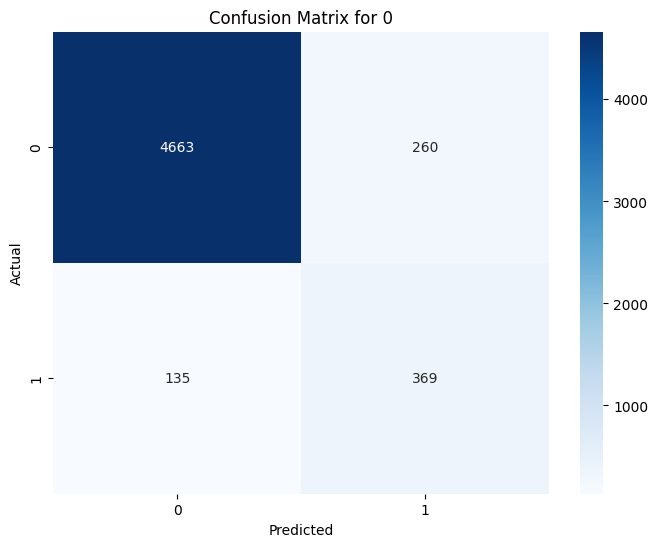

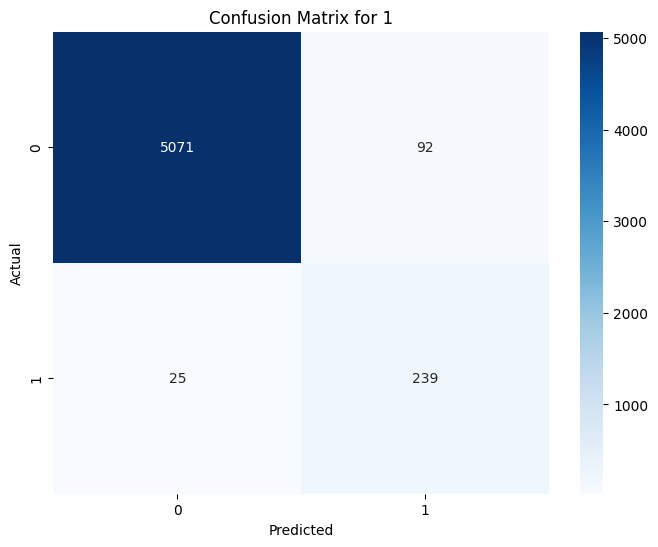

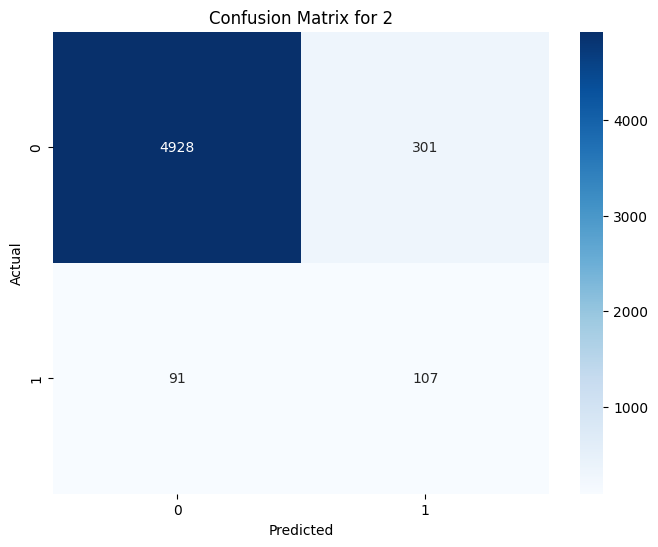

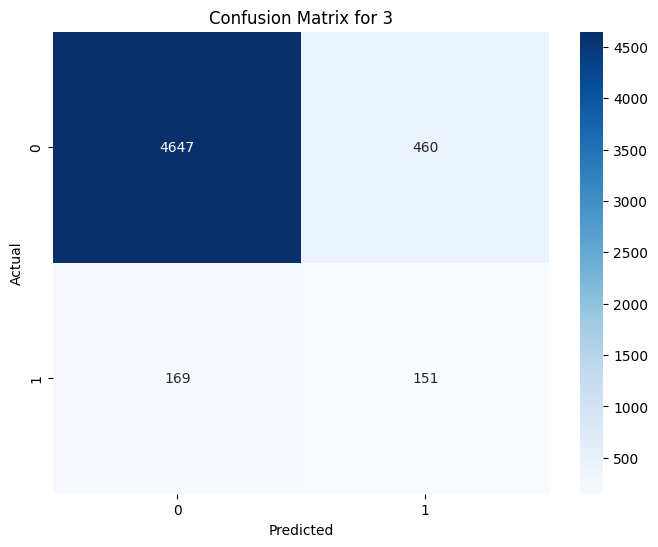

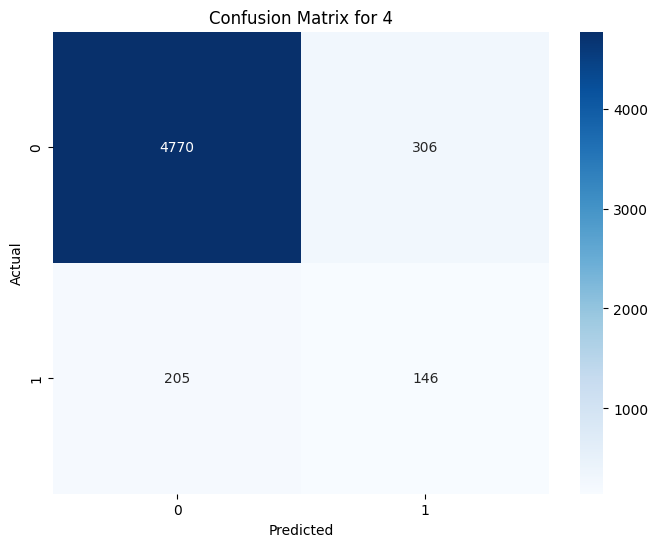

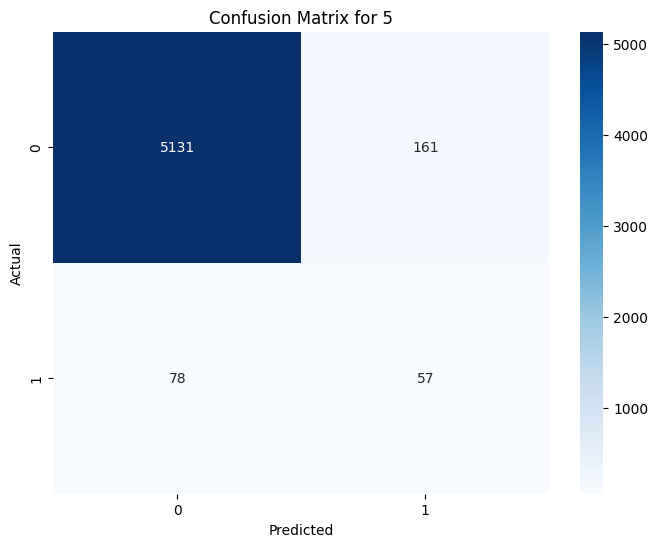

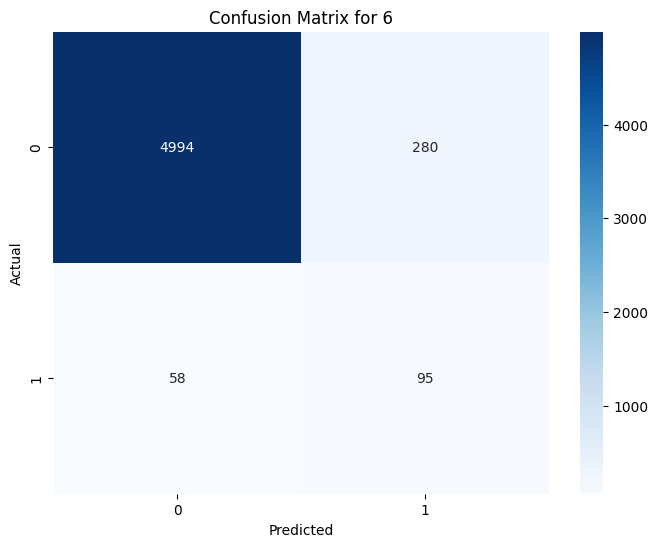

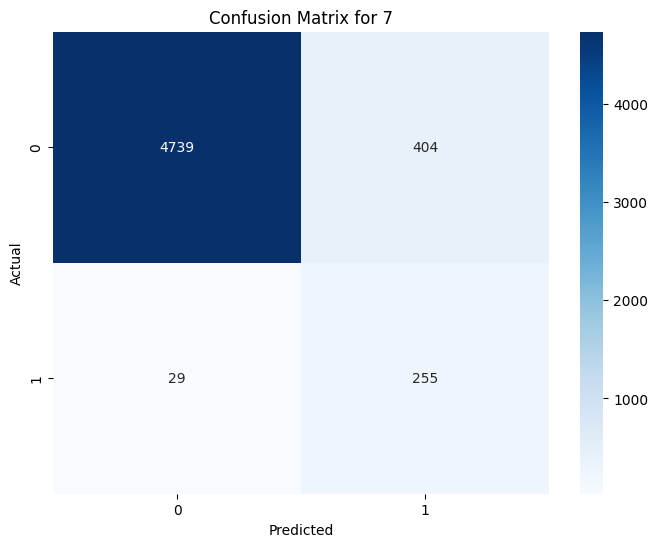

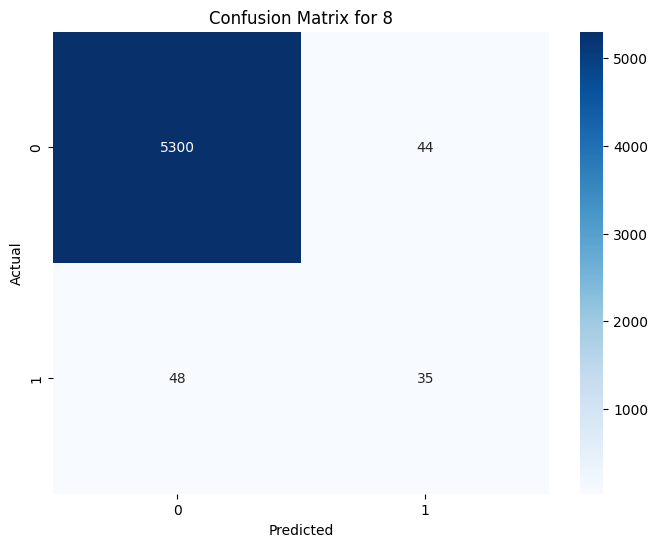

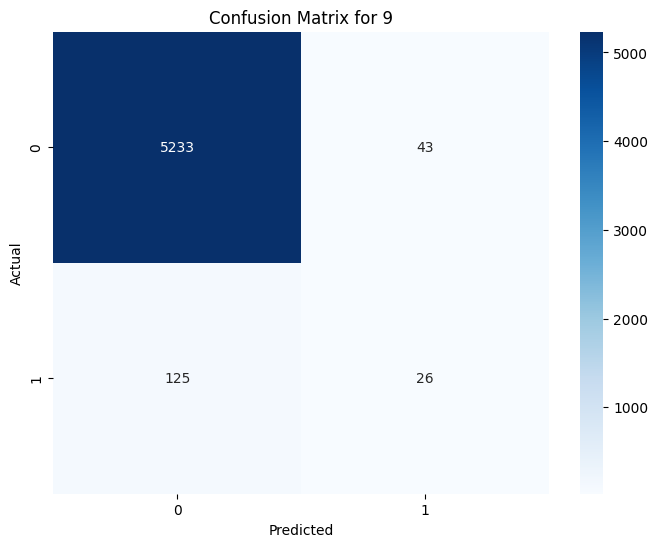

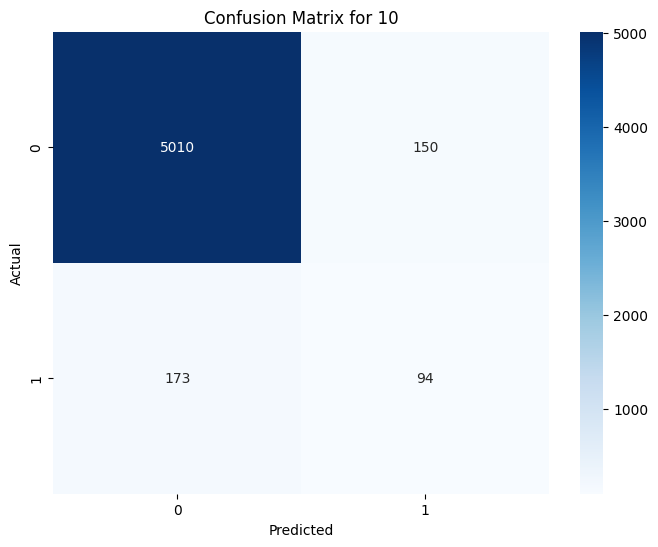

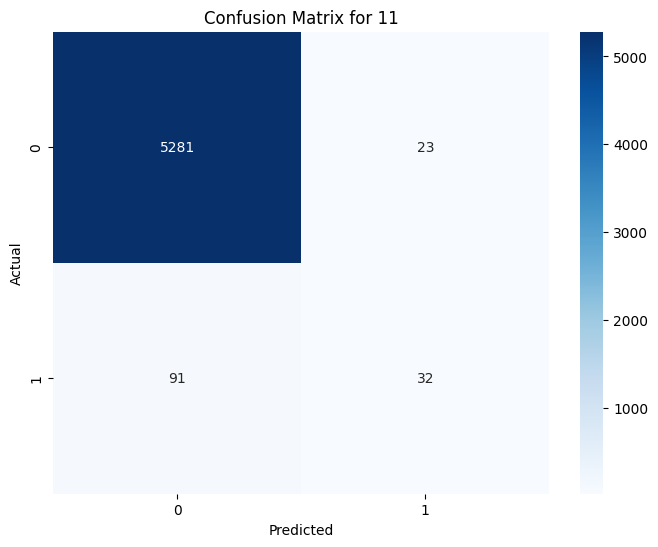

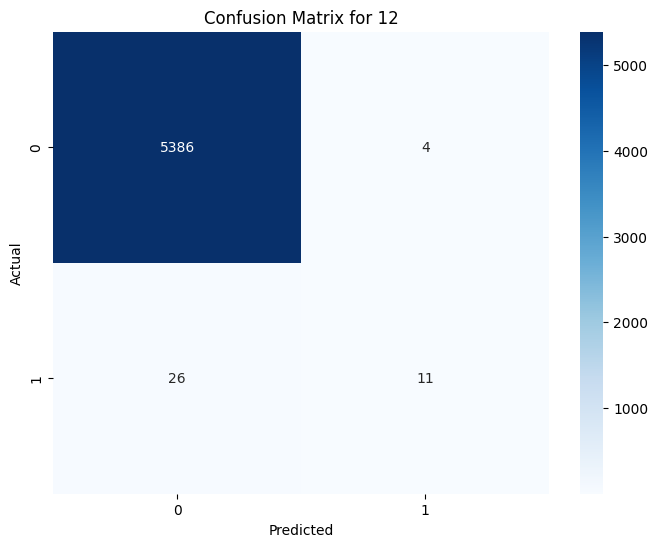

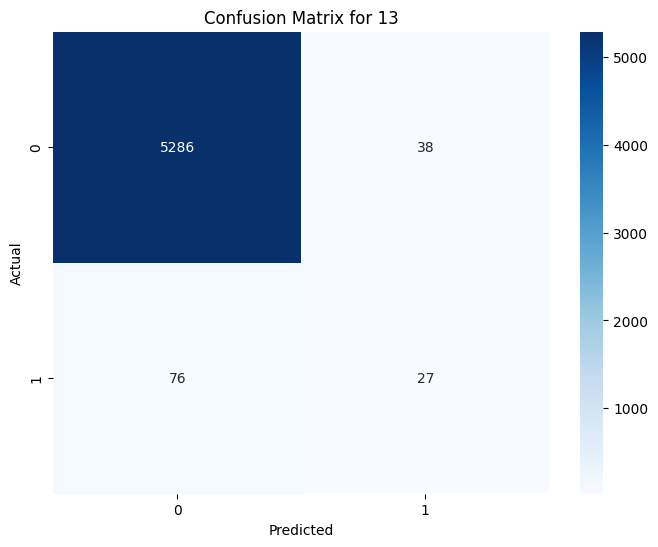

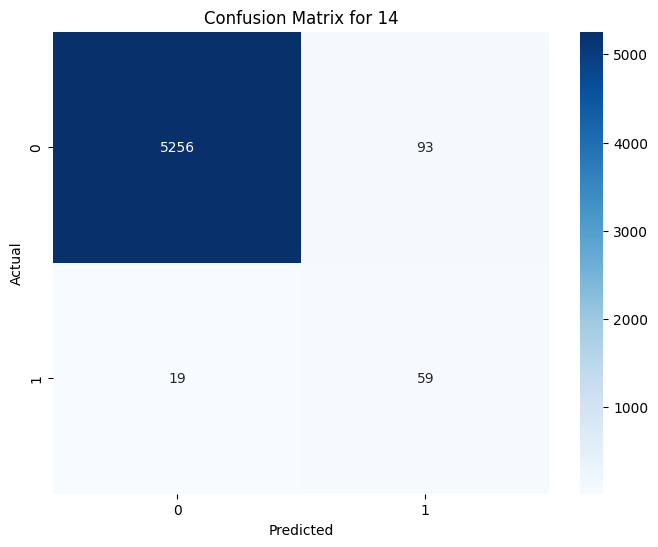

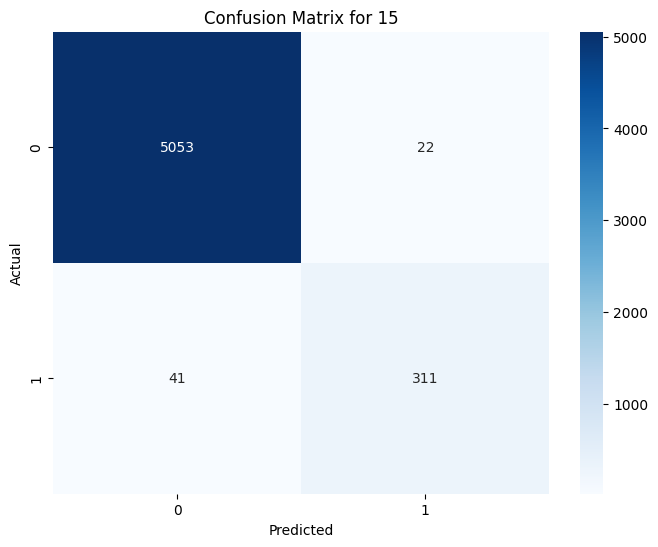

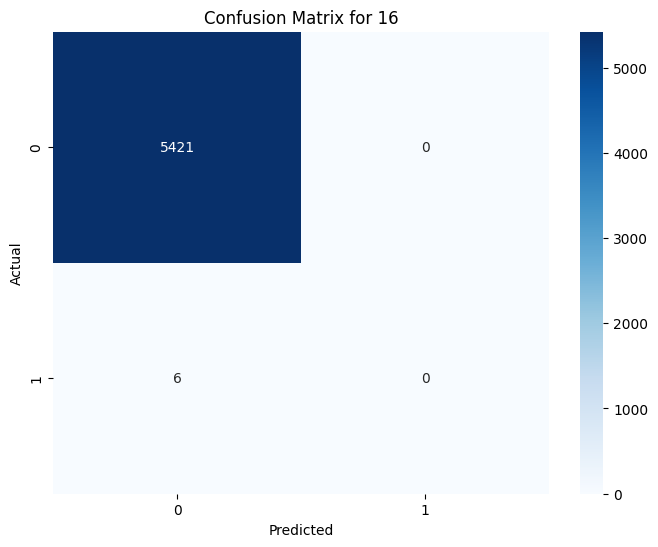

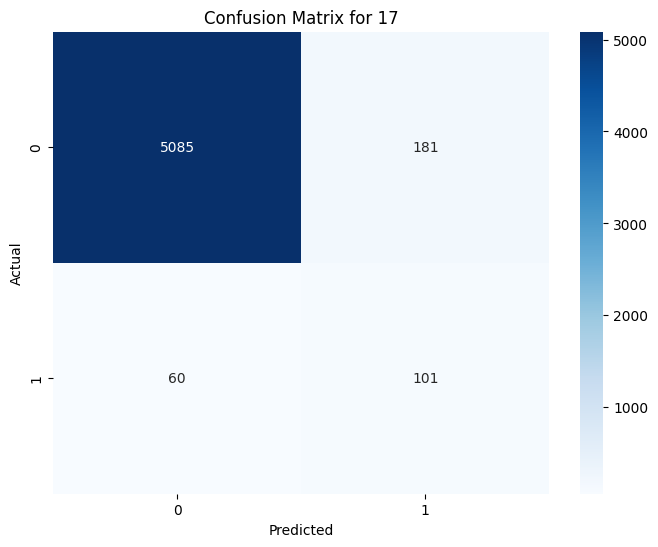

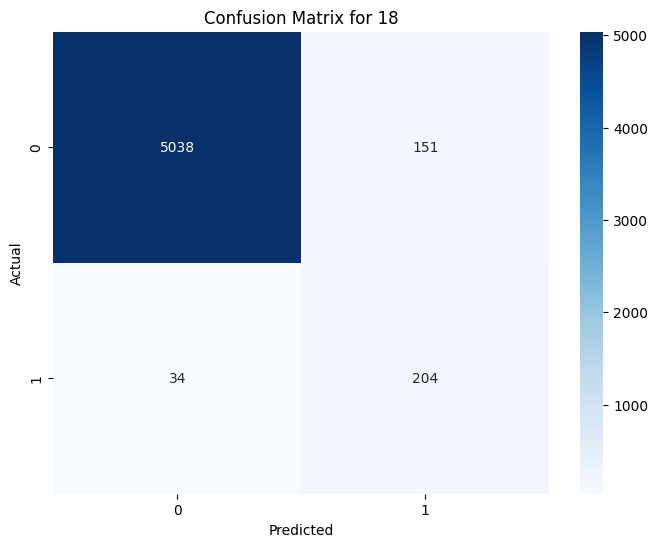

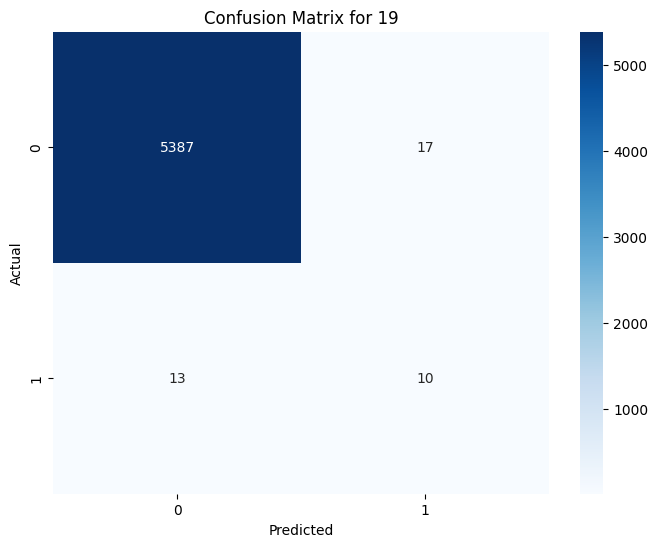

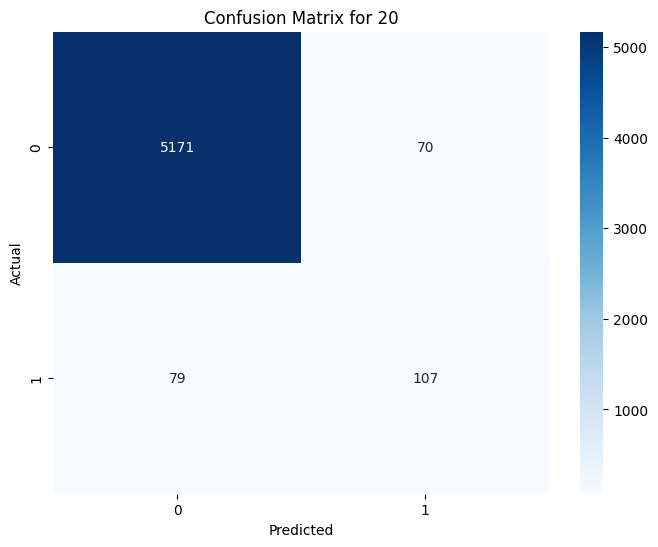

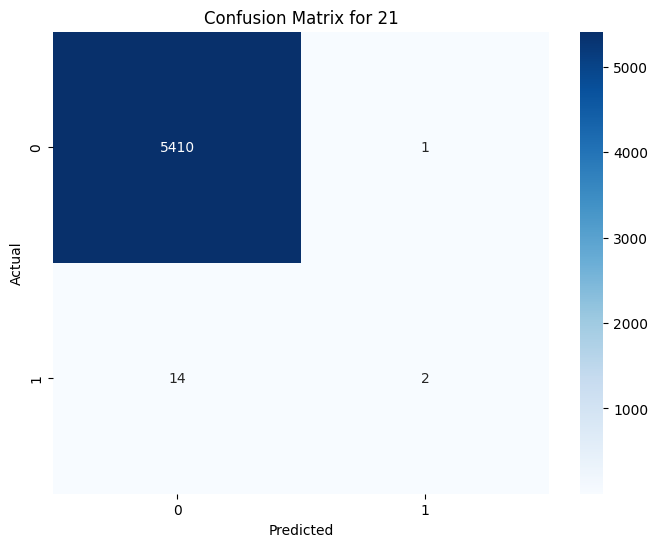

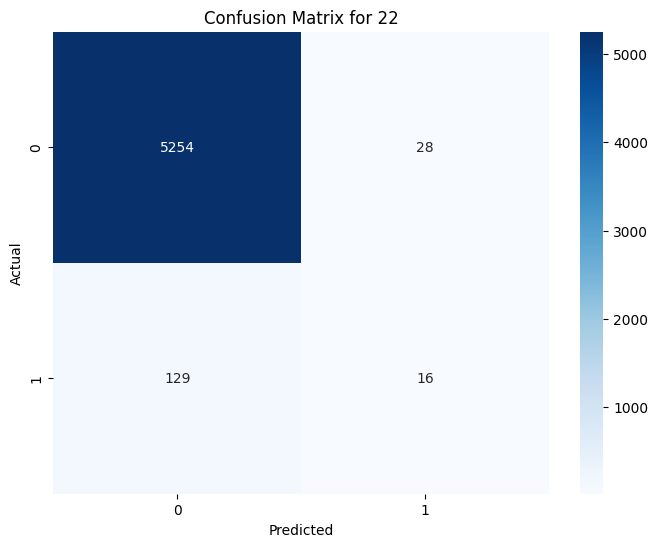

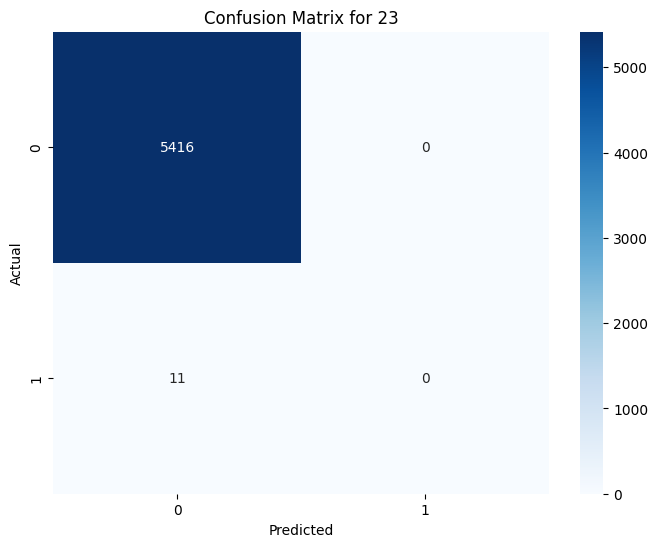

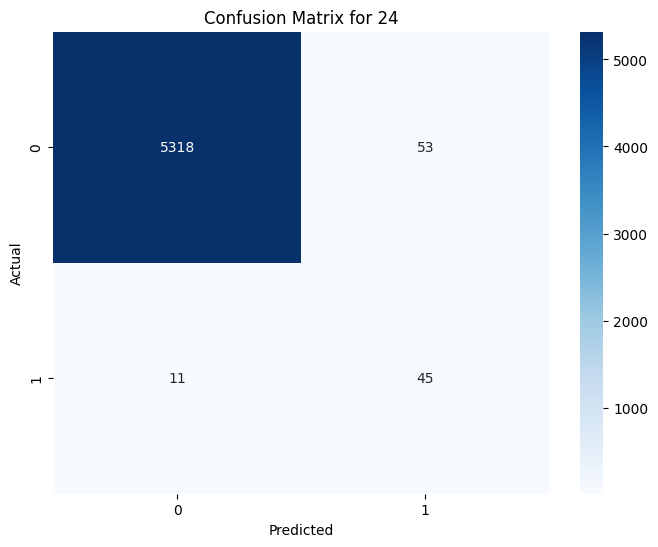

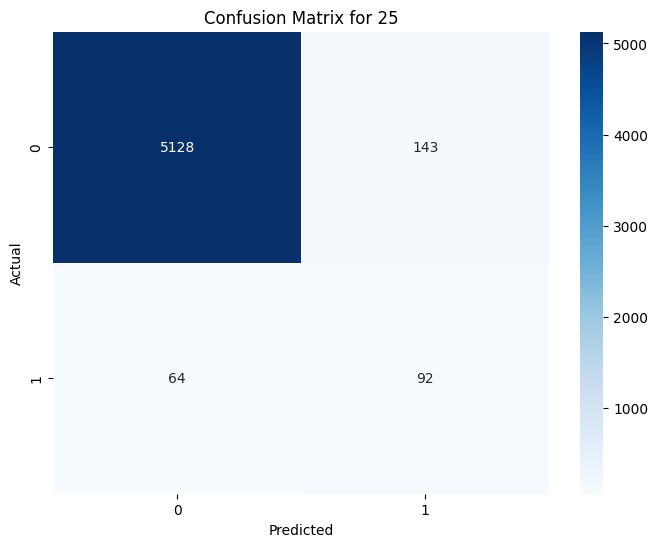

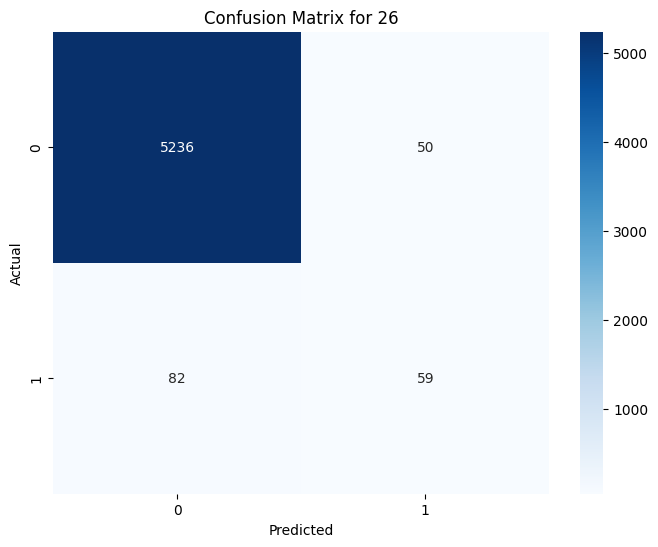

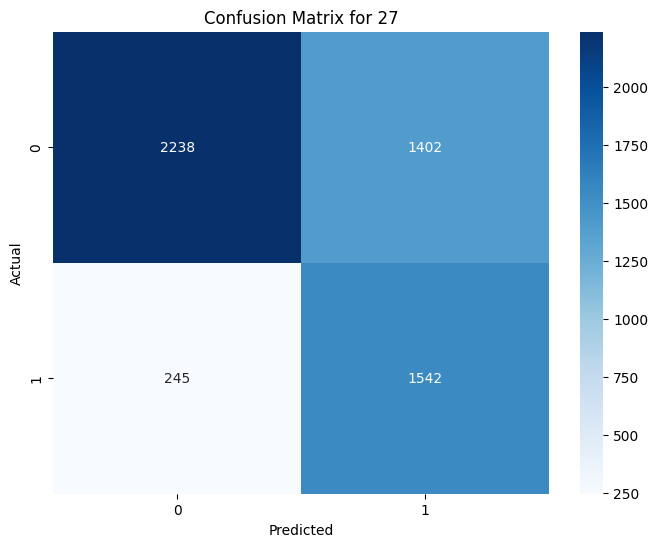

In [ ]:
# Визуализация confusion matrix для всех эмоций
confusion_mtx = multilabel_confusion_matrix(test_labels, bert_predictions)
for i, emotion in enumerate(mlb.classes_):
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_mtx[i], annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {emotion}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

Общая точность: Большинство эмоций показывают высокую точность (accuracy), что свидетельствует о хорошем общем качестве модели. Однако, есть несколько эмоций с низким количеством примеров, для которых наблюдаются проблемы с точностью и полнотой.

Эмоции с высокой поддержкой: Эмоции с высокими значениями точности, полноты и F1 (например, эмоции 0, 1, 5, 6, 8, 12, 15) демонстрируют хорошую способность модели к классификации этих эмоций. Особенно выделяются эмоции с точностью и полнотой выше 0.90 для класса 0, что указывает на правильную классификацию наиболее частых эмоций.

Эмоции с низкой поддержкой: Для эмоций с малым количеством примеров (например, эмоции 16, 19, 23, 24) модель сталкивается с трудностями. Такие эмоции часто имеют низкую полноту для класса 1, что может быть связано с недостаточным количеством примеров для обучения или сложностью классификации этих эмоций. Это приводит к высокому значению точности для класса 0 и низкому recall для класса 1.

Дисбаланс классов: Большинство эмоций имеют значительный дисбаланс между классами 0 и 1, что подтверждается высокими значениями точности для класса 0 и низкой полнотой для класса 1. Это указывает на проблему с переобучением на преобладающий класс 0 и затруднениями в классификации класса 1, особенно для эмоций с низкой поддержкой.

Наиболее проблемные эмоции: Эмоции, такие как grief, relief, fear (эмоции с индексами 9, 10, 16, 19), демонстрируют очень низкие значения F1 (ниже 0.3), что свидетельствует о трудности модели в их распознавании. Это может быть связано с высокой субъективностью этих эмоций или сильным пересечением с другими эмоциями, что мешает точному прогнозированию.

Эмоция neutral: Эмоция "neutral" (эмоция 16) выделяется тем, что модель имеет очень высокую точность и полноту для этой категории, что свидетельствует о хорошей способности модели различать нейтральные тексты от эмоциональных. Эта эмоция имеет самые сбалансированные метрики среди всех классов, что делает ее одной из наиболее надежных для классификации.

Эмоции с большой сложностью: Эмоции с большими вариациями в precision и recall (например, 3, 7, 9, 19) требуют дополнительной работы для улучшения классификации, возможно через увеличение данных для обучающих выборок или применение методов балансировки классов.

## Выводы

Baseline:
Макро-усредненная точность (precision): 0.2176
Макро-усредненная полнота (recall): 0.5147
Макро-усредненный F1-скор: 0.2928
Accuracy: 0.1118

Experiment 1:
Макро-усредненная точность (precision): 0.5730
Макро-усредненная полнота (recall): 0.1868
Макро-усредненный F1-скор: 0.2498
Accuracy: 0.1819

Experiment 2:
Макро-усредненная точность (precision): 0.4341
Макро-усредненная полнота (recall): 0.4935
Макро-усредненный F1-скор: 0.4276
Accuracy: 0.3136

По итогу, как и ожидалось, самый сложный с точки зрения архитектуры подход, а именно трансформер, показал самые лучшие результаты. XGBoost показал сравнительные результаты с baseline. Если сравнивать xgboost и baseline, то у первой модели значительно выше точность, а у второй - полнота, первая решила предсказывать метку только в условиях сильной уверенности, а вторая предсказывать всегда побольше меток, тогда какие-то из них совпадут. Хотя у xgboost ниже f1 мера, но выше accuracy и precision в отдельности, и в целом нам его подход больше нравится, поэтому мы все же считаем, что он справился лучше baseline. В целом все 3 подхода достойно справились с такой сложной задачей